In [1]:
#利用前面生成的训练集和验证集图片的名字，生成直接供yolov4模型使用的txt文件，文件中每行包括图片路径  和  图中每个物体的坐标、类别
import xml.etree.ElementTree as ET
from os import getcwd

#sets=[('2007', 'train_465_2'), ('2007', 'val_465_2'), ('2007', 'test_465_2')]#可以在此处修改txt文件名
sets=[('2007', 'train_148_5'), ('2007', 'val_148_5')]#可以在此处修改txt文件名

wd = getcwd()
#classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
classes = ["num"]

def convert_annotation(year, image_id, list_file):
    in_file = open('VOCdevkit/VOC%s/Annotations_148_5_1/%s.xml'%(year, image_id))#可以修改标注路径
    tree=ET.parse(in_file)
    root = tree.getroot()
    list_file.write('%s/VOCdevkit/VOC%s/JPEGImages_148_5_1/%s.png'%(wd, year, image_id))#这里图片是png格式  可以修改图片路径
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    list_file.write('\n')

for year, image_set in sets:
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        convert_annotation(year, image_id, list_file)
    list_file.close()

In [2]:
#构建yolov4模型框架的辅助类
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from collections import OrderedDict

#-------------------------------------------------#
#   MISH激活函数
#-------------------------------------------------#
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

#-------------------------------------------------#
#   卷积块
#   CONV+BATCHNORM+MISH
#-------------------------------------------------#
class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(BasicConv, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, kernel_size//2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = Mish()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

#---------------------------------------------------#
#   CSPdarknet的结构块的组成部分
#   内部堆叠的残差块
#---------------------------------------------------#
class Resblock(nn.Module):
    def __init__(self, channels, hidden_channels=None, residual_activation=nn.Identity()):
        super(Resblock, self).__init__()

        if hidden_channels is None:
            hidden_channels = channels

        self.block = nn.Sequential(
            BasicConv(channels, hidden_channels, 1),
            BasicConv(hidden_channels, channels, 3)
        )

    def forward(self, x):
        return x + self.block(x)

#---------------------------------------------------#
#   CSPdarknet的结构块
#   存在一个大残差边
#   这个大残差边绕过了很多的残差结构
#---------------------------------------------------#
class Resblock_body(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, first):
        super(Resblock_body, self).__init__()

        self.downsample_conv = BasicConv(in_channels, out_channels, 3, stride=2)

        if first:
            self.split_conv0 = BasicConv(out_channels, out_channels, 1)
            self.split_conv1 = BasicConv(out_channels, out_channels, 1)  
            self.blocks_conv = nn.Sequential(
                Resblock(channels=out_channels, hidden_channels=out_channels//2),
                BasicConv(out_channels, out_channels, 1)
            )
            self.concat_conv = BasicConv(out_channels*2, out_channels, 1)
        else:
            self.split_conv0 = BasicConv(out_channels, out_channels//2, 1)
            self.split_conv1 = BasicConv(out_channels, out_channels//2, 1)

            self.blocks_conv = nn.Sequential(
                *[Resblock(out_channels//2) for _ in range(num_blocks)],
                BasicConv(out_channels//2, out_channels//2, 1)
            )
            self.concat_conv = BasicConv(out_channels, out_channels, 1)

    def forward(self, x):
        x = self.downsample_conv(x)

        x0 = self.split_conv0(x)

        x1 = self.split_conv1(x)
        x1 = self.blocks_conv(x1)

        x = torch.cat([x1, x0], dim=1)
        x = self.concat_conv(x)

        return x

class CSPDarkNet(nn.Module):
    def __init__(self, layers):
        super(CSPDarkNet, self).__init__()
        self.inplanes = 32
        self.conv1 = BasicConv(3, self.inplanes, kernel_size=3, stride=1)
        self.feature_channels = [64, 128, 256, 512, 1024]

        self.stages = nn.ModuleList([
            Resblock_body(self.inplanes, self.feature_channels[0], layers[0], first=True),
            Resblock_body(self.feature_channels[0], self.feature_channels[1], layers[1], first=False),
            Resblock_body(self.feature_channels[1], self.feature_channels[2], layers[2], first=False),
            Resblock_body(self.feature_channels[2], self.feature_channels[3], layers[3], first=False),
            Resblock_body(self.feature_channels[3], self.feature_channels[4], layers[4], first=False)
        ])

        self.num_features = 1
        # 进行权值初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, x):
        x = self.conv1(x)

        x = self.stages[0](x)
        x = self.stages[1](x)
        out3 = self.stages[2](x)
        out4 = self.stages[3](out3)
        out5 = self.stages[4](out4)

        return out3, out4, out5

def darknet53(pretrained, **kwargs):
    model = CSPDarkNet([1, 2, 8, 8, 4])
    if pretrained:
        if isinstance(pretrained, str):
            model.load_state_dict(torch.load(pretrained))
        else:
            raise Exception("darknet request a pretrained path. got [{}]".format(pretrained))
    return model

In [3]:
#构建yolov4模型
import torch
import torch.nn as nn
from collections import OrderedDict

def conv2d(filter_in, filter_out, kernel_size, stride=1):
    pad = (kernel_size - 1) // 2 if kernel_size else 0
    return nn.Sequential(OrderedDict([
        ("conv", nn.Conv2d(filter_in, filter_out, kernel_size=kernel_size, stride=stride, padding=pad, bias=False)),
        ("bn", nn.BatchNorm2d(filter_out)),
        ("relu", nn.LeakyReLU(0.1)),
    ]))

#---------------------------------------------------#
#   SPP结构，利用不同大小的池化核进行池化
#   池化后堆叠
#---------------------------------------------------#
class SpatialPyramidPooling(nn.Module):
    def __init__(self, pool_sizes=[5, 9, 13]):
        super(SpatialPyramidPooling, self).__init__()

        self.maxpools = nn.ModuleList([nn.MaxPool2d(pool_size, 1, pool_size//2) for pool_size in pool_sizes])

    def forward(self, x):
        features = [maxpool(x) for maxpool in self.maxpools[::-1]]
        features = torch.cat(features + [x], dim=1)

        return features

#---------------------------------------------------#
#   卷积 + 上采样
#---------------------------------------------------#
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()

        self.upsample = nn.Sequential(
            conv2d(in_channels, out_channels, 1),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

    def forward(self, x,):
        x = self.upsample(x)
        return x

#---------------------------------------------------#
#   三次卷积块
#---------------------------------------------------#
def make_three_conv(filters_list, in_filters):
    m = nn.Sequential(
        conv2d(in_filters, filters_list[0], 1),
        conv2d(filters_list[0], filters_list[1], 3),
        conv2d(filters_list[1], filters_list[0], 1),
    )
    return m

#---------------------------------------------------#
#   五次卷积块
#---------------------------------------------------#
def make_five_conv(filters_list, in_filters):
    m = nn.Sequential(
        conv2d(in_filters, filters_list[0], 1),
        conv2d(filters_list[0], filters_list[1], 3),
        conv2d(filters_list[1], filters_list[0], 1),
        conv2d(filters_list[0], filters_list[1], 3),
        conv2d(filters_list[1], filters_list[0], 1),
    )
    return m

#---------------------------------------------------#
#   最后获得yolov4的输出
#---------------------------------------------------#
def yolo_head(filters_list, in_filters):
    m = nn.Sequential(
        conv2d(in_filters, filters_list[0], 3),
        nn.Conv2d(filters_list[0], filters_list[1], 1),
    )
    return m

#---------------------------------------------------#
#   yolo_body
#---------------------------------------------------#
class YoloBody(nn.Module):
    def __init__(self, num_anchors, num_classes):
        super(YoloBody, self).__init__()
        #  backbone
        self.backbone = darknet53(None)

        self.conv1 = make_three_conv([512,1024],1024)
        self.SPP = SpatialPyramidPooling()
        self.conv2 = make_three_conv([512,1024],2048)

        self.upsample1 = Upsample(512,256)
        self.conv_for_P4 = conv2d(512,256,1)
        self.make_five_conv1 = make_five_conv([256, 512],512)

        self.upsample2 = Upsample(256,128)
        self.conv_for_P3 = conv2d(256,128,1)
        self.make_five_conv2 = make_five_conv([128, 256],256)
        # 3*(5+num_classes)=3*(5+20)=3*(4+1+20)=75
        # 4+1+num_classes
        final_out_filter2 = num_anchors * (5 + num_classes)
        self.yolo_head3 = yolo_head([256, final_out_filter2],128)

        self.down_sample1 = conv2d(128,256,3,stride=2)
        self.make_five_conv3 = make_five_conv([256, 512],512)
        # 3*(5+num_classes)=3*(5+20)=3*(4+1+20)=75
        final_out_filter1 =  num_anchors * (5 + num_classes)
        self.yolo_head2 = yolo_head([512, final_out_filter1],256)


        self.down_sample2 = conv2d(256,512,3,stride=2)
        self.make_five_conv4 = make_five_conv([512, 1024],1024)
        # 3*(5+num_classes)=3*(5+20)=3*(4+1+20)=75
        final_out_filter0 =  num_anchors * (5 + num_classes)
        self.yolo_head1 = yolo_head([1024, final_out_filter0],512)


    def forward(self, x):
        #  backbone
        x2, x1, x0 = self.backbone(x)

        P5 = self.conv1(x0)
        P5 = self.SPP(P5)
        P5 = self.conv2(P5)

        P5_upsample = self.upsample1(P5)
        P4 = self.conv_for_P4(x1)
        P4 = torch.cat([P4,P5_upsample],axis=1)
        P4 = self.make_five_conv1(P4)

        P4_upsample = self.upsample2(P4)
        P3 = self.conv_for_P3(x2)
        P3 = torch.cat([P3,P4_upsample],axis=1)
        P3 = self.make_five_conv2(P3)

        P3_downsample = self.down_sample1(P3)
        P4 = torch.cat([P3_downsample,P4],axis=1)
        P4 = self.make_five_conv3(P4)

        P4_downsample = self.down_sample2(P4)
        P5 = torch.cat([P4_downsample,P5],axis=1)
        P5 = self.make_five_conv4(P5)

        out2 = self.yolo_head3(P3)
        out1 = self.yolo_head2(P4)
        out0 = self.yolo_head1(P5)

        return out0, out1, out2

In [4]:
#其他工具函数
from __future__ import division
import os
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

class DecodeBox(nn.Module):
    def __init__(self, anchors, num_classes, img_size):
        super(DecodeBox, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.bbox_attrs = 5 + num_classes
        self.img_size = img_size

    def forward(self, input):
        # input为bs,3*(1+4+num_classes),13,13

        # 一共多少张图片
        batch_size = input.size(0)
        # 13，13
        input_height = input.size(2)
        input_width = input.size(3)

        # 计算步长
        # 每一个特征点对应原来的图片上多少个像素点
        # 如果特征层为13x13的话，一个特征点就对应原来的图片上的32个像素点
        # 416/13 = 32
        stride_h = self.img_size[1] / input_height
        stride_w = self.img_size[0] / input_width

        # 把先验框的尺寸调整成特征层大小的形式
        # 计算出先验框在特征层上对应的宽高
        scaled_anchors = [(anchor_width / stride_w, anchor_height / stride_h) for anchor_width, anchor_height in self.anchors]

        # bs,3*(5+num_classes),13,13 -> bs,3,13,13,(5+num_classes)
        prediction = input.view(batch_size, self.num_anchors,
                                self.bbox_attrs, input_height, input_width).permute(0, 1, 3, 4, 2).contiguous()

        # 先验框的中心位置的调整参数
        x = torch.sigmoid(prediction[..., 0])  
        y = torch.sigmoid(prediction[..., 1])
        # 先验框的宽高调整参数
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height

        # 获得置信度，是否有物体
        conf = torch.sigmoid(prediction[..., 4])
        # 种类置信度
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor

        # 生成网格，先验框中心，网格左上角 batch_size,3,13,13
        grid_x = torch.linspace(0, input_width - 1, input_width).repeat(input_width, 1).repeat(
            batch_size * self.num_anchors, 1, 1).view(x.shape).type(FloatTensor)
        grid_y = torch.linspace(0, input_height - 1, input_height).repeat(input_height, 1).t().repeat(
            batch_size * self.num_anchors, 1, 1).view(y.shape).type(FloatTensor)

        # 生成先验框的宽高
        anchor_w = FloatTensor(scaled_anchors).index_select(1, LongTensor([0]))
        anchor_h = FloatTensor(scaled_anchors).index_select(1, LongTensor([1]))
        anchor_w = anchor_w.repeat(batch_size, 1).repeat(1, 1, input_height * input_width).view(w.shape)
        anchor_h = anchor_h.repeat(batch_size, 1).repeat(1, 1, input_height * input_width).view(h.shape)
        
        # 计算调整后的先验框中心与宽高
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + grid_x
        pred_boxes[..., 1] = y.data + grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * anchor_h

        # fig = plt.figure()
        # ax = fig.add_subplot(121)
        # if input_height==13:
        #     plt.ylim(0,13)
        #     plt.xlim(0,13)
        # elif input_height==26:
        #     plt.ylim(0,26)
        #     plt.xlim(0,26)
        # elif input_height==52:
        #     plt.ylim(0,52)
        #     plt.xlim(0,52)
        # plt.scatter(grid_x.cpu(),grid_y.cpu())

        # anchor_left = grid_x - anchor_w/2 
        # anchor_top = grid_y - anchor_h/2 

        # rect1 = plt.Rectangle([anchor_left[0,0,5,5],anchor_top[0,0,5,5]],anchor_w[0,0,5,5],anchor_h[0,0,5,5],color="r",fill=False)
        # rect2 = plt.Rectangle([anchor_left[0,1,5,5],anchor_top[0,1,5,5]],anchor_w[0,1,5,5],anchor_h[0,1,5,5],color="r",fill=False)
        # rect3 = plt.Rectangle([anchor_left[0,2,5,5],anchor_top[0,2,5,5]],anchor_w[0,2,5,5],anchor_h[0,2,5,5],color="r",fill=False)

        # ax.add_patch(rect1)
        # ax.add_patch(rect2)
        # ax.add_patch(rect3)

        # ax = fig.add_subplot(122)
        # if input_height==13:
        #     plt.ylim(0,13)
        #     plt.xlim(0,13)
        # elif input_height==26:
        #     plt.ylim(0,26)
        #     plt.xlim(0,26)
        # elif input_height==52:
        #     plt.ylim(0,52)
        #     plt.xlim(0,52)
        # plt.scatter(grid_x.cpu(),grid_y.cpu())
        # plt.scatter(pred_boxes[0,:,5,5,0].cpu(),pred_boxes[0,:,5,5,1].cpu(),c='r')

        # pre_left = pred_boxes[...,0] - pred_boxes[...,2]/2 
        # pre_top = pred_boxes[...,1] - pred_boxes[...,3]/2 

        # rect1 = plt.Rectangle([pre_left[0,0,5,5],pre_top[0,0,5,5]],pred_boxes[0,0,5,5,2],pred_boxes[0,0,5,5,3],color="r",fill=False)
        # rect2 = plt.Rectangle([pre_left[0,1,5,5],pre_top[0,1,5,5]],pred_boxes[0,1,5,5,2],pred_boxes[0,1,5,5,3],color="r",fill=False)
        # rect3 = plt.Rectangle([pre_left[0,2,5,5],pre_top[0,2,5,5]],pred_boxes[0,2,5,5,2],pred_boxes[0,2,5,5,3],color="r",fill=False)

        # ax.add_patch(rect1)
        # ax.add_patch(rect2)
        # ax.add_patch(rect3)

        # plt.show()
        # 用于将输出调整为相对于416x416的大小
        _scale = torch.Tensor([stride_w, stride_h] * 2).type(FloatTensor)
        output = torch.cat((pred_boxes.view(batch_size, -1, 4) * _scale,
                            conf.view(batch_size, -1, 1), pred_cls.view(batch_size, -1, self.num_classes)), -1)
        return output.data
        
def letterbox_image(image, size):
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def yolo_correct_boxes(top, left, bottom, right, input_shape, image_shape):
    new_shape = image_shape*np.min(input_shape/image_shape)

    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape

    box_yx = np.concatenate(((top+bottom)/2,(left+right)/2),axis=-1)/input_shape
    box_hw = np.concatenate((bottom-top,right-left),axis=-1)/input_shape

    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  np.concatenate([
        box_mins[:, 0:1],
        box_mins[:, 1:2],
        box_maxes[:, 0:1],
        box_maxes[:, 1:2]
    ],axis=-1)
    print(np.shape(boxes))
    boxes *= np.concatenate([image_shape, image_shape],axis=-1)
    return boxes

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
        计算IOU
    """
    if not x1y1x2y2:
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)

    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * \
                 torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
                 
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
    # 求左上角和右下角
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # 利用置信度进行第一轮筛选
        conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
        image_pred = image_pred[conf_mask]

        if not image_pred.size(0):
            continue

        # 获得种类及其置信度
        class_conf, class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1, keepdim=True)

        # 获得的内容为(x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)

        # 获得种类
        unique_labels = detections[:, -1].cpu().unique()

        if prediction.is_cuda:
            unique_labels = unique_labels.cuda()

        for c in unique_labels:
            # 获得某一类初步筛选后全部的预测结果
            detections_class = detections[detections[:, -1] == c]
            # 按照存在物体的置信度排序
            _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
            detections_class = detections_class[conf_sort_index]
            # 进行非极大抑制
            max_detections = []
            while detections_class.size(0):
                # 取出这一类置信度最高的，一步一步往下判断，判断重合程度是否大于nms_thres，如果是则去除掉
                max_detections.append(detections_class[0].unsqueeze(0))
                if len(detections_class) == 1:
                    break
                ious = bbox_iou(max_detections[-1], detections_class[1:])
                detections_class = detections_class[1:][ious < nms_thres]
            # 堆叠
            max_detections = torch.cat(max_detections).data
            # Add max detections to outputs
            output[image_i] = max_detections if output[image_i] is None else torch.cat(
                (output[image_i], max_detections))

    return output

def merge_bboxes(bboxes, cutx, cuty):
    merge_bbox = []
    for i in range(len(bboxes)):
        for box in bboxes[i]:
            tmp_box = []
            x1,y1,x2,y2 = box[0], box[1], box[2], box[3]

            if i == 0:
                if y1 > cuty or x1 > cutx:
                    continue
                if y2 >= cuty and y1 <= cuty:
                    y2 = cuty
                    if y2-y1 < 5:
                        continue
                if x2 >= cutx and x1 <= cutx:
                    x2 = cutx
                    if x2-x1 < 5:
                        continue
                
            if i == 1:
                if y2 < cuty or x1 > cutx:
                    continue

                if y2 >= cuty and y1 <= cuty:
                    y1 = cuty
                    if y2-y1 < 5:
                        continue
                
                if x2 >= cutx and x1 <= cutx:
                    x2 = cutx
                    if x2-x1 < 5:
                        continue

            if i == 2:
                if y2 < cuty or x2 < cutx:
                    continue

                if y2 >= cuty and y1 <= cuty:
                    y1 = cuty
                    if y2-y1 < 5:
                        continue

                if x2 >= cutx and x1 <= cutx:
                    x1 = cutx
                    if x2-x1 < 5:
                        continue

            if i == 3:
                if y1 > cuty or x2 < cutx:
                    continue

                if y2 >= cuty and y1 <= cuty:
                    y2 = cuty
                    if y2-y1 < 5:
                        continue

                if x2 >= cutx and x1 <= cutx:
                    x1 = cutx
                    if x2-x1 < 5:
                        continue

            tmp_box.append(x1)
            tmp_box.append(y1)
            tmp_box.append(x2)
            tmp_box.append(y2)
            tmp_box.append(box[-1])
            merge_bbox.append(tmp_box)
    return merge_bbox

In [5]:
#yolov4模型训练使用的辅助函数和辅助类   包括各种损失函数 以及数据增强方式
import cv2  
from random import shuffle
import numpy as np
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from PIL import Image

def jaccard(_box_a, _box_b):
    b1_x1, b1_x2 = _box_a[:, 0] - _box_a[:, 2] / 2, _box_a[:, 0] + _box_a[:, 2] / 2
    b1_y1, b1_y2 = _box_a[:, 1] - _box_a[:, 3] / 2, _box_a[:, 1] + _box_a[:, 3] / 2
    b2_x1, b2_x2 = _box_b[:, 0] - _box_b[:, 2] / 2, _box_b[:, 0] + _box_b[:, 2] / 2
    b2_y1, b2_y2 = _box_b[:, 1] - _box_b[:, 3] / 2, _box_b[:, 1] + _box_b[:, 3] / 2
    box_a = torch.zeros_like(_box_a)
    box_b = torch.zeros_like(_box_b)
    box_a[:, 0], box_a[:, 1], box_a[:, 2], box_a[:, 3] = b1_x1, b1_y1, b1_x2, b1_y2
    box_b[:, 0], box_b[:, 1], box_b[:, 2], box_b[:, 3] = b2_x1, b2_y1, b2_x2, b2_y2
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)

    inter = inter[:, :, 0] * inter[:, :, 1]
    # 计算先验框和真实框各自的面积
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    # 求IOU
    union = area_a + area_b - inter
    return inter / union  # [A,B]
#---------------------------------------------------#
#   平滑标签
#---------------------------------------------------#
def smooth_labels(y_true, label_smoothing,num_classes):
    return y_true * (1.0 - label_smoothing) + label_smoothing / num_classes

def box_ciou(b1, b2):
    """
    输入为：
    ----------
    b1: tensor, shape=(batch, feat_w, feat_h, anchor_num, 4), xywh
    b2: tensor, shape=(batch, feat_w, feat_h, anchor_num, 4), xywh

    返回为：
    -------
    ciou: tensor, shape=(batch, feat_w, feat_h, anchor_num, 1)
    """
    # 求出预测框左上角右下角
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh/2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half
    # 求出真实框左上角右下角
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half

    # 求真实框和预测框所有的iou
    intersect_mins = torch.max(b1_mins, b2_mins)
    intersect_maxes = torch.min(b1_maxes, b2_maxes)
    intersect_wh = torch.max(intersect_maxes - intersect_mins, torch.zeros_like(intersect_maxes))
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    union_area = b1_area + b2_area - intersect_area
    iou = intersect_area / torch.clamp(union_area,min = 1e-6)

    # 计算中心的差距
    center_distance = torch.sum(torch.pow((b1_xy - b2_xy), 2), axis=-1)
    
    # 找到包裹两个框的最小框的左上角和右下角
    enclose_mins = torch.min(b1_mins, b2_mins)
    enclose_maxes = torch.max(b1_maxes, b2_maxes)
    enclose_wh = torch.max(enclose_maxes - enclose_mins, torch.zeros_like(intersect_maxes))
    # 计算对角线距离
    enclose_diagonal = torch.sum(torch.pow(enclose_wh,2), axis=-1)
    ciou = iou - 1.0 * (center_distance) / torch.clamp(enclose_diagonal,min = 1e-6)
    
    v = (4 / (math.pi ** 2)) * torch.pow((torch.atan(b1_wh[..., 0]/torch.clamp(b1_wh[..., 1],min = 1e-6)) - torch.atan(b2_wh[..., 0]/torch.clamp(b2_wh[..., 1],min = 1e-6))), 2)
    alpha = v / torch.clamp((1.0 - iou + v),min=1e-6)
    ciou = ciou - alpha * v
    return ciou
  
def clip_by_tensor(t,t_min,t_max):
    t=t.float()
    result = (t >= t_min).float() * t + (t < t_min).float() * t_min
    result = (result <= t_max).float() * result + (result > t_max).float() * t_max
    return result

def MSELoss(pred,target):
    return (pred-target)**2

def BCELoss(pred,target):
    epsilon = 1e-7
    pred = clip_by_tensor(pred, epsilon, 1.0 - epsilon)
    output = -target * torch.log(pred) - (1.0 - target) * torch.log(1.0 - pred)
    return output

class YOLOLoss(nn.Module):
    def __init__(self, anchors, num_classes, img_size, label_smooth=0, cuda=True):
        super(YOLOLoss, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.bbox_attrs = 5 + num_classes
        self.img_size = img_size
        self.feature_length = [img_size[0]//32,img_size[0]//16,img_size[0]//8]
        self.label_smooth = label_smooth

        self.ignore_threshold = 0.5
        self.lambda_conf = 1.0
        self.lambda_cls = 1.0
        self.lambda_loc = 1.0
        self.cuda = cuda

    def forward(self, input, targets=None):
        # input为bs,3*(5+num_classes),13,13
        
        # 一共多少张图片
        bs = input.size(0)
        # 特征层的高
        in_h = input.size(2)
        # 特征层的宽
        in_w = input.size(3)

        # 计算步长
        # 每一个特征点对应原来的图片上多少个像素点
        # 如果特征层为13x13的话，一个特征点就对应原来的图片上的32个像素点
        stride_h = self.img_size[1] / in_h
        stride_w = self.img_size[0] / in_w

        # 把先验框的尺寸调整成特征层大小的形式
        # 计算出先验框在特征层上对应的宽高
        scaled_anchors = [(a_w / stride_w, a_h / stride_h) for a_w, a_h in self.anchors]
        # bs,3*(5+num_classes),13,13 -> bs,3,13,13,(5+num_classes)
        prediction = input.view(bs, int(self.num_anchors/3),
                                self.bbox_attrs, in_h, in_w).permute(0, 1, 3, 4, 2).contiguous()
        
        # 对prediction预测进行调整
        conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # 找到哪些先验框内部包含物体
        mask, noobj_mask, t_box, tconf, tcls, box_loss_scale_x, box_loss_scale_y = self.get_target(targets, scaled_anchors,in_w, in_h,self.ignore_threshold)

        noobj_mask, pred_boxes_for_ciou = self.get_ignore(prediction, targets, scaled_anchors, in_w, in_h, noobj_mask)

        if self.cuda:
            mask, noobj_mask = mask.cuda(), noobj_mask.cuda()
            box_loss_scale_x, box_loss_scale_y= box_loss_scale_x.cuda(), box_loss_scale_y.cuda()
            tconf, tcls = tconf.cuda(), tcls.cuda()
            pred_boxes_for_ciou = pred_boxes_for_ciou.cuda()
            t_box = t_box.cuda()

        box_loss_scale = 2-box_loss_scale_x*box_loss_scale_y
        #  losses.
        ciou = (1 - box_ciou( pred_boxes_for_ciou[mask.bool()], t_box[mask.bool()]))* box_loss_scale[mask.bool()]

        loss_loc = torch.sum(ciou / bs)
        loss_conf = torch.sum(BCELoss(conf, mask) * mask / bs) + \
                    torch.sum(BCELoss(conf, mask) * noobj_mask / bs)
                    
        # print(smooth_labels(tcls[mask == 1],self.label_smooth,self.num_classes))
        loss_cls = torch.sum(BCELoss(pred_cls[mask == 1], smooth_labels(tcls[mask == 1],self.label_smooth,self.num_classes))/bs)
        # print(loss_loc,loss_conf,loss_cls)
        loss = loss_conf * self.lambda_conf + loss_cls * self.lambda_cls + loss_loc * self.lambda_loc
        return loss, loss_conf.item(), loss_cls.item(), loss_loc.item()

    def get_target(self, target, anchors, in_w, in_h, ignore_threshold):
        # 计算一共有多少张图片
        bs = len(target)
        # 获得先验框
        anchor_index = [[0,1,2],[3,4,5],[6,7,8]][self.feature_length.index(in_w)]
        subtract_index = [0,3,6][self.feature_length.index(in_w)]
        # 创建全是0或者全是1的阵列
        mask = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)
        noobj_mask = torch.ones(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)

        tx = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)
        ty = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)
        tw = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)
        th = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)
        t_box = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, 4, requires_grad=False)
        tconf = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)
        tcls = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, self.num_classes, requires_grad=False)

        box_loss_scale_x = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)
        box_loss_scale_y = torch.zeros(bs, int(self.num_anchors/3), in_h, in_w, requires_grad=False)
        for b in range(bs):
            for t in range(target[b].shape[0]):
                # 计算出在特征层上的点位
                gx = target[b][t, 0] * in_w
                gy = target[b][t, 1] * in_h
                
                gw = target[b][t, 2] * in_w
                gh = target[b][t, 3] * in_h

                # 计算出属于哪个网格
                gi = int(gx)
                gj = int(gy)

                # 计算真实框的位置
                gt_box = torch.FloatTensor(np.array([0, 0, gw, gh])).unsqueeze(0)
                
                # 计算出所有先验框的位置
                anchor_shapes = torch.FloatTensor(np.concatenate((np.zeros((self.num_anchors, 2)),
                                                                  np.array(anchors)), 1))
                # 计算重合程度
                anch_ious = bbox_iou(gt_box, anchor_shapes)
               
                # Find the best matching anchor box
                best_n = np.argmax(anch_ious)
                if best_n not in anchor_index:
                    continue
                # Masks
                if (gj < in_h) and (gi < in_w):
                    best_n = best_n - subtract_index
                    # 判定哪些先验框内部真实的存在物体
                    noobj_mask[b, best_n, gj, gi] = 0
                    mask[b, best_n, gj, gi] = 1
                    # 计算先验框中心调整参数
                    tx[b, best_n, gj, gi] = gx
                    ty[b, best_n, gj, gi] = gy
                    # 计算先验框宽高调整参数
                    tw[b, best_n, gj, gi] = gw
                    th[b, best_n, gj, gi] = gh
                    # 用于获得xywh的比例
                    box_loss_scale_x[b, best_n, gj, gi] = target[b][t, 2]
                    box_loss_scale_y[b, best_n, gj, gi] = target[b][t, 3]
                    # 物体置信度
                    tconf[b, best_n, gj, gi] = 1
                    # 种类
                    tcls[b, best_n, gj, gi, int(target[b][t, 4])] = 1
                else:
                    print('Step {0} out of bound'.format(b))
                    print('gj: {0}, height: {1} | gi: {2}, width: {3}'.format(gj, in_h, gi, in_w))
                    continue
        t_box[...,0] = tx
        t_box[...,1] = ty
        t_box[...,2] = tw
        t_box[...,3] = th
        return mask, noobj_mask, t_box, tconf, tcls, box_loss_scale_x, box_loss_scale_y

    def get_ignore(self,prediction,target,scaled_anchors,in_w, in_h,noobj_mask):
        bs = len(target)
        anchor_index = [[0,1,2],[3,4,5],[6,7,8]][self.feature_length.index(in_w)]
        scaled_anchors = np.array(scaled_anchors)[anchor_index]
        # 先验框的中心位置的调整参数
        x = torch.sigmoid(prediction[..., 0])  
        y = torch.sigmoid(prediction[..., 1])
        # 先验框的宽高调整参数
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height

        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor

        # 生成网格，先验框中心，网格左上角
        grid_x = torch.linspace(0, in_w - 1, in_w).repeat(in_w, 1).repeat(
            int(bs*self.num_anchors/3), 1, 1).view(x.shape).type(FloatTensor)
        grid_y = torch.linspace(0, in_h - 1, in_h).repeat(in_h, 1).t().repeat(
            int(bs*self.num_anchors/3), 1, 1).view(y.shape).type(FloatTensor)

        # 生成先验框的宽高
        anchor_w = FloatTensor(scaled_anchors).index_select(1, LongTensor([0]))
        anchor_h = FloatTensor(scaled_anchors).index_select(1, LongTensor([1]))
        
        anchor_w = anchor_w.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(w.shape)
        anchor_h = anchor_h.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(h.shape)
        
        # 计算调整后的先验框中心与宽高
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x + grid_x
        pred_boxes[..., 1] = y + grid_y
        pred_boxes[..., 2] = torch.exp(w) * anchor_w
        pred_boxes[..., 3] = torch.exp(h) * anchor_h
        for i in range(bs):
            pred_boxes_for_ignore = pred_boxes[i]
            pred_boxes_for_ignore = pred_boxes_for_ignore.view(-1, 4)
            if len(target[i]) > 0:
                gx = target[i][:, 0:1] * in_w
                gy = target[i][:, 1:2] * in_h
                gw = target[i][:, 2:3] * in_w
                gh = target[i][:, 3:4] * in_h
                gt_box = torch.FloatTensor(np.concatenate([gx, gy, gw, gh],-1)).type(FloatTensor)

                anch_ious = jaccard(gt_box, pred_boxes_for_ignore)
                for t in range(target[i].shape[0]):
                    anch_iou = anch_ious[t].view(pred_boxes[i].size()[:3])
                    noobj_mask[i][anch_iou>self.ignore_threshold] = 0
        return noobj_mask, pred_boxes


def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a


class Generator(object):
    def __init__(self,batch_size,
                 train_lines, image_size,
                 ):
        
        self.batch_size = batch_size
        self.train_lines = train_lines
        self.train_batches = len(train_lines)
        self.image_size = image_size
        
    def get_random_data(self, annotation_line, input_shape, jitter=.3, hue=.1, sat=1.5, val=1.5):
        '''r实时数据增强的随机预处理'''
        line = annotation_line.split()
        image = Image.open(line[0])
        iw, ih = image.size
        h, w = input_shape
        box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])

        # resize image
        new_ar = w/h * rand(1-jitter,1+jitter)/rand(1-jitter,1+jitter)
        scale = rand(.25, 2)
        if new_ar < 1:
            nh = int(scale*h)
            nw = int(nh*new_ar)
        else:
            nw = int(scale*w)
            nh = int(nw/new_ar)
        image = image.resize((nw,nh), Image.BICUBIC)

        # place image
        dx = int(rand(0, w-nw))
        dy = int(rand(0, h-nh))
        new_image = Image.new('RGB', (w,h), (128,128,128))
        new_image.paste(image, (dx, dy))
        image = new_image

        # flip image or not
        flip = rand()<.5
        if flip: image = image.transpose(Image.FLIP_LEFT_RIGHT)

        # distort image
        hue = rand(-hue, hue)
        sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
        val = rand(1, val) if rand()<.5 else 1/rand(1, val)
        x = cv2.cvtColor(np.array(image,np.float32)/255, cv2.COLOR_RGB2HSV)
        x[..., 0] += hue*360
        x[..., 0][x[..., 0]>1] -= 1
        x[..., 0][x[..., 0]<0] += 1
        x[..., 1] *= sat
        x[..., 2] *= val
        x[x[:,:, 0]>360, 0] = 360
        x[:, :, 1:][x[:, :, 1:]>1] = 1
        x[x<0] = 0
        image_data = cv2.cvtColor(x, cv2.COLOR_HSV2RGB)*255

        # correct boxes
        box_data = np.zeros((len(box),5))
        if len(box)>0:
            np.random.shuffle(box)
            box[:, [0,2]] = box[:, [0,2]]*nw/iw + dx
            box[:, [1,3]] = box[:, [1,3]]*nh/ih + dy
            if flip: box[:, [0,2]] = w - box[:, [2,0]]
            box[:, 0:2][box[:, 0:2]<0] = 0
            box[:, 2][box[:, 2]>w] = w
            box[:, 3][box[:, 3]>h] = h
            box_w = box[:, 2] - box[:, 0]
            box_h = box[:, 3] - box[:, 1]
            box = box[np.logical_and(box_w>1, box_h>1)] # discard invalid box
            box_data = np.zeros((len(box),5))
            box_data[:len(box)] = box
        if len(box) == 0:
            return image_data, []

        if (box_data[:,:4]>0).any():
            return image_data, box_data
        else:
            return image_data, []

    def get_random_data_with_Mosaic(self, annotation_line, input_shape, hue=.1, sat=1.5, val=1.5):
        '''random preprocessing for real-time data augmentation'''
        h, w = input_shape
        min_offset_x = 0.4
        min_offset_y = 0.4
        scale_low = 1-min(min_offset_x,min_offset_y)
        scale_high = scale_low+0.2

        image_datas = [] 
        box_datas = []
        index = 0

        place_x = [0,0,int(w*min_offset_x),int(w*min_offset_x)]
        place_y = [0,int(h*min_offset_y),int(w*min_offset_y),0]
        for line in annotation_line:
            # 每一行进行分割
            line_content = line.split()
            # 打开图片
            image = Image.open(line_content[0])
            image = image.convert("RGB") 
            # 图片的大小
            iw, ih = image.size
            # 保存框的位置
            box = np.array([np.array(list(map(int,box.split(',')))) for box in line_content[1:]])
            
            # 是否翻转图片
            flip = rand()<.5
            if flip and len(box)>0:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                box[:, [0,2]] = iw - box[:, [2,0]]

            # 对输入进来的图片进行缩放
            new_ar = w/h
            scale = rand(scale_low, scale_high)
            if new_ar < 1:
                nh = int(scale*h)
                nw = int(nh*new_ar)
            else:
                nw = int(scale*w)
                nh = int(nw/new_ar)
            image = image.resize((nw,nh), Image.BICUBIC)

            # 进行色域变换
            hue = rand(-hue, hue)
            sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
            val = rand(1, val) if rand()<.5 else 1/rand(1, val)
            x = cv2.cvtColor(np.array(image,np.float32)/255, cv2.COLOR_RGB2HSV)
            x[..., 0] += hue*360
            x[..., 0][x[..., 0]>1] -= 1
            x[..., 0][x[..., 0]<0] += 1
            x[..., 1] *= sat
            x[..., 2] *= val
            x[x[:,:, 0]>360, 0] = 360
            x[:, :, 1:][x[:, :, 1:]>1] = 1
            x[x<0] = 0
            image = cv2.cvtColor(x, cv2.COLOR_HSV2RGB) # numpy array, 0 to 1
            
            image = Image.fromarray((image*255).astype(np.uint8))
            # 将图片进行放置，分别对应四张分割图片的位置
            dx = place_x[index]
            dy = place_y[index]
            new_image = Image.new('RGB', (w,h), (128,128,128))
            new_image.paste(image, (dx, dy))
            image_data = np.array(new_image)

            
            index = index + 1
            box_data = []
            # 对box进行重新处理
            if len(box)>0:
                np.random.shuffle(box)
                box[:, [0,2]] = box[:, [0,2]]*nw/iw + dx
                box[:, [1,3]] = box[:, [1,3]]*nh/ih + dy
                box[:, 0:2][box[:, 0:2]<0] = 0
                box[:, 2][box[:, 2]>w] = w
                box[:, 3][box[:, 3]>h] = h
                box_w = box[:, 2] - box[:, 0]
                box_h = box[:, 3] - box[:, 1]
                box = box[np.logical_and(box_w>1, box_h>1)]
                box_data = np.zeros((len(box),5))
                box_data[:len(box)] = box
            
            image_datas.append(image_data)
            box_datas.append(box_data)

        # 将图片分割，放在一起
        cutx = np.random.randint(int(w*min_offset_x), int(w*(1 - min_offset_x)))
        cuty = np.random.randint(int(h*min_offset_y), int(h*(1 - min_offset_y)))

        new_image = np.zeros([h,w,3])
        new_image[:cuty, :cutx, :] = image_datas[0][:cuty, :cutx, :]
        new_image[cuty:, :cutx, :] = image_datas[1][cuty:, :cutx, :]
        new_image[cuty:, cutx:, :] = image_datas[2][cuty:, cutx:, :]
        new_image[:cuty, cutx:, :] = image_datas[3][:cuty, cutx:, :]

        # 对框进行进一步的处理
        new_boxes = np.array(merge_bboxes(box_datas, cutx, cuty))

        if len(new_boxes) == 0:
            return new_image, []
        if (new_boxes[:,:4]>0).any():
            return new_image, new_boxes
        else:
            return new_image, []

    def generate(self, train = True, mosaic = True):
        while True:
            shuffle(self.train_lines)
            lines = self.train_lines
            inputs = []
            targets = []
            flag = True
            n = len(lines)
            for i in range(len(lines)):
                if mosaic == True:
                    if flag and (i+4) < n:
                        img,y = self.get_random_data_with_Mosaic(lines[i:i+4], self.image_size[0:2])
                        i = (i+4) % n
                    else:
                        img,y = self.get_random_data(lines[i], self.image_size[0:2])
                        i = (i+1) % n
                    flag = bool(1-flag)
                else:
                    img,y = self.get_random_data(lines[i], self.image_size[0:2])
                    i = (i+1) % n
                if len(y)!=0:
                    boxes = np.array(y[:,:4],dtype=np.float32)
                    boxes[:,0] = boxes[:,0]/self.image_size[1]
                    boxes[:,1] = boxes[:,1]/self.image_size[0]
                    boxes[:,2] = boxes[:,2]/self.image_size[1]
                    boxes[:,3] = boxes[:,3]/self.image_size[0]

                    boxes = np.maximum(np.minimum(boxes,1),0)
                    boxes[:,2] = boxes[:,2] - boxes[:,0]
                    boxes[:,3] = boxes[:,3] - boxes[:,1]
    
                    boxes[:,0] = boxes[:,0] + boxes[:,2]/2
                    boxes[:,1] = boxes[:,1] + boxes[:,3]/2
                    y = np.concatenate([boxes,y[:,-1:]],axis=-1)
                    
                img = np.array(img,dtype = np.float32)

                inputs.append(np.transpose(img/255.0,(2,0,1)))              
                targets.append(np.array(y,dtype = np.float32))
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield tmp_inp, tmp_targets


In [6]:
#数据加载器
from random import shuffle
import numpy as np
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import cv2

class YoloDataset(Dataset):
    def __init__(self, train_lines, image_size, mosaic=True):
        super(YoloDataset, self).__init__()

        self.train_lines = train_lines
        self.train_batches = len(train_lines)
        self.image_size = image_size
        self.mosaic = mosaic
        self.flag = True

    def __len__(self):
        return self.train_batches

    def rand(self, a=0, b=1):
        return np.random.rand() * (b - a) + a

    def get_random_data(self, annotation_line, input_shape, jitter=.3, hue=.1, sat=1.5, val=1.5):
        """实时数据增强的随机预处理"""
        line = annotation_line.split()
        image = Image.open(line[0])
        iw, ih = image.size
        h, w = input_shape
        box = np.array([np.array(list(map(int, box.split(',')))) for box in line[1:]])

        # 调整图片大小
        new_ar = w / h * self.rand(1 - jitter, 1 + jitter) / self.rand(1 - jitter, 1 + jitter)
        scale = self.rand(.25, 2)
        if new_ar < 1:
            nh = int(scale * h)
            nw = int(nh * new_ar)
        else:
            nw = int(scale * w)
            nh = int(nw / new_ar)
        image = image.resize((nw, nh), Image.BICUBIC)

        # 放置图片
        dx = int(self.rand(0, w - nw))
        dy = int(self.rand(0, h - nh))
        new_image = Image.new('RGB', (w, h),
                              (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)))
        new_image.paste(image, (dx, dy))
        image = new_image

        # 是否翻转图片
        flip = self.rand() < .5
        if flip:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        # 色域变换
        hue = self.rand(-hue, hue)
        sat = self.rand(1, sat) if self.rand() < .5 else 1 / self.rand(1, sat)
        val = self.rand(1, val) if self.rand() < .5 else 1 / self.rand(1, val)
        x = cv2.cvtColor(np.array(image,np.float32)/255, cv2.COLOR_RGB2HSV)
        x[..., 0] += hue*360
        x[..., 0][x[..., 0]>1] -= 1
        x[..., 0][x[..., 0]<0] += 1
        x[..., 1] *= sat
        x[..., 2] *= val
        x[x[:,:, 0]>360, 0] = 360
        x[:, :, 1:][x[:, :, 1:]>1] = 1
        x[x<0] = 0
        image_data = cv2.cvtColor(x, cv2.COLOR_HSV2RGB)*255

        # 调整目标框坐标
        box_data = np.zeros((len(box), 5))
        if len(box) > 0:
            np.random.shuffle(box)
            box[:, [0, 2]] = box[:, [0, 2]] * nw / iw + dx
            box[:, [1, 3]] = box[:, [1, 3]] * nh / ih + dy
            if flip:
                box[:, [0, 2]] = w - box[:, [2, 0]]
            box[:, 0:2][box[:, 0:2] < 0] = 0
            box[:, 2][box[:, 2] > w] = w
            box[:, 3][box[:, 3] > h] = h
            box_w = box[:, 2] - box[:, 0]
            box_h = box[:, 3] - box[:, 1]
            box = box[np.logical_and(box_w > 1, box_h > 1)]  # 保留有效框
            box_data = np.zeros((len(box), 5))
            box_data[:len(box)] = box
        if len(box) == 0:
            return image_data, []

        if (box_data[:, :4] > 0).any():
            return image_data, box_data
        else:
            return image_data, []

    def get_random_data_with_Mosaic(self, annotation_line, input_shape, hue=.1, sat=1.5, val=1.5):
        h, w = input_shape
        min_offset_x = 0.3
        min_offset_y = 0.3
        scale_low = 1 - min(min_offset_x, min_offset_y)
        scale_high = scale_low + 0.2

        image_datas = []
        box_datas = []
        index = 0

        place_x = [0, 0, int(w * min_offset_x), int(w * min_offset_x)]
        place_y = [0, int(h * min_offset_y), int(w * min_offset_y), 0]
        for line in annotation_line:
            # 每一行进行分割
            line_content = line.split()
            # 打开图片
            image = Image.open(line_content[0])
            image = image.convert("RGB")
            # 图片的大小
            iw, ih = image.size
            # 保存框的位置
            box = np.array([np.array(list(map(int, box.split(',')))) for box in line_content[1:]])

            # 是否翻转图片
            flip = self.rand() < .5
            if flip and len(box) > 0:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                box[:, [0, 2]] = iw - box[:, [2, 0]]

            # 对输入进来的图片进行缩放
            new_ar = w / h
            scale = self.rand(scale_low, scale_high)
            if new_ar < 1:
                nh = int(scale * h)
                nw = int(nh * new_ar)
            else:
                nw = int(scale * w)
                nh = int(nw / new_ar)
            image = image.resize((nw, nh), Image.BICUBIC)

            # 进行色域变换
            hue = self.rand(-hue, hue)
            sat = self.rand(1, sat) if self.rand() < .5 else 1 / self.rand(1, sat)
            val = self.rand(1, val) if self.rand() < .5 else 1 / self.rand(1, val)
            x = cv2.cvtColor(np.array(image,np.float32)/255, cv2.COLOR_RGB2HSV)
            x[..., 0] += hue*360
            x[..., 0][x[..., 0]>1] -= 1
            x[..., 0][x[..., 0]<0] += 1
            x[..., 1] *= sat
            x[..., 2] *= val
            x[x[:,:, 0]>360, 0] = 360
            x[:, :, 1:][x[:, :, 1:]>1] = 1
            x[x<0] = 0
            image = cv2.cvtColor(x, cv2.COLOR_HSV2RGB) # numpy array, 0 to 1

            image = Image.fromarray((image * 255).astype(np.uint8))
            # 将图片进行放置，分别对应四张分割图片的位置
            dx = place_x[index]
            dy = place_y[index]
            new_image = Image.new('RGB', (w, h),
                                  (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)))
            new_image.paste(image, (dx, dy))
            image_data = np.array(new_image)

            index = index + 1
            box_data = []
            # 对box进行重新处理
            if len(box) > 0:
                np.random.shuffle(box)
                box[:, [0, 2]] = box[:, [0, 2]] * nw / iw + dx
                box[:, [1, 3]] = box[:, [1, 3]] * nh / ih + dy
                box[:, 0:2][box[:, 0:2] < 0] = 0
                box[:, 2][box[:, 2] > w] = w
                box[:, 3][box[:, 3] > h] = h
                box_w = box[:, 2] - box[:, 0]
                box_h = box[:, 3] - box[:, 1]
                box = box[np.logical_and(box_w > 1, box_h > 1)]
                box_data = np.zeros((len(box), 5))
                box_data[:len(box)] = box

            image_datas.append(image_data)
            box_datas.append(box_data)

        # 将图片分割，放在一起
        cutx = np.random.randint(int(w * min_offset_x), int(w * (1 - min_offset_x)))
        cuty = np.random.randint(int(h * min_offset_y), int(h * (1 - min_offset_y)))

        new_image = np.zeros([h, w, 3])
        new_image[:cuty, :cutx, :] = image_datas[0][:cuty, :cutx, :]
        new_image[cuty:, :cutx, :] = image_datas[1][cuty:, :cutx, :]
        new_image[cuty:, cutx:, :] = image_datas[2][cuty:, cutx:, :]
        new_image[:cuty, cutx:, :] = image_datas[3][:cuty, cutx:, :]

        # 对框进行进一步的处理
        new_boxes = np.array(merge_bboxes(box_datas, cutx, cuty))

        if len(new_boxes) == 0:
            return new_image, []
        if (new_boxes[:, :4] > 0).any():
            return new_image, new_boxes
        else:
            return new_image, []

    def __getitem__(self, index):
        if index == 0:
            shuffle(self.train_lines)
        lines = self.train_lines
        n = self.train_batches
        index = index % n
        if self.mosaic:
            if self.flag and (index + 4) < n:
                img, y = self.get_random_data_with_Mosaic(lines[index:index + 4], self.image_size[0:2])
            else:
                img, y = self.get_random_data(lines[index], self.image_size[0:2])
            self.flag = bool(1-self.flag)
        else:
            img, y = self.get_random_data(lines[index], self.image_size[0:2])

        if len(y) != 0:
            # 从坐标转换成0~1的百分比
            boxes = np.array(y[:, :4], dtype=np.float32)
            boxes[:, 0] = boxes[:, 0] / self.image_size[1]
            boxes[:, 1] = boxes[:, 1] / self.image_size[0]
            boxes[:, 2] = boxes[:, 2] / self.image_size[1]
            boxes[:, 3] = boxes[:, 3] / self.image_size[0]

            boxes = np.maximum(np.minimum(boxes, 1), 0)
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            boxes[:, 0] = boxes[:, 0] + boxes[:, 2] / 2
            boxes[:, 1] = boxes[:, 1] + boxes[:, 3] / 2
            y = np.concatenate([boxes, y[:, -1:]], axis=-1)

        img = np.array(img, dtype=np.float32)

        tmp_inp = np.transpose(img / 255.0, (2, 0, 1))
        tmp_targets = np.array(y, dtype=np.float32)
        return tmp_inp, tmp_targets


# DataLoader中collate_fn使用
def yolo_dataset_collate(batch):
    images = []
    bboxes = []
    for img, box in batch:
        images.append(img)
        bboxes.append(box)
    images = np.array(images)
    bboxes = np.array(bboxes)
    return images, bboxes

In [7]:
#-----------------------------------------------------版本三  更改中断之后加载模型的方式  以及权重衰减的方式--------------------------
"""版本三   这里是从头开始训练训练加载yolo4模型的代码   """
#-------------------------------------#
#       对数据集进行训练
#-------------------------------------#
import os
import numpy as np
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from utils.dataloader import yolo_dataset_collate, YoloDataset
from nets.yolo_training import YOLOLoss,Generator
from nets.yolo4 import YoloBody
from tqdm import tqdm



#---------------------------------------------------#
#   获得类和先验框
#---------------------------------------------------#
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape([-1,3,2])[::-1,:,:]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_epoch(net,yolo_losses,epoch,epoch_size,epoch_size_val,gen,genval,Epoch,cuda):
    total_loss = 0
    val_loss = 0
    start_time = time.time()
    with tqdm(total=epoch_size,desc=f'Epoch {epoch + 1}/{Epoch}',postfix=dict,mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            if iteration >= epoch_size:
                break
            images, targets = batch[0], batch[1]
            with torch.no_grad():
                if cuda:
                    images = Variable(torch.from_numpy(images).type(torch.FloatTensor)).cuda()
                    targets = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets]
                else:
                    images = Variable(torch.from_numpy(images).type(torch.FloatTensor))
                    targets = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets]
            optimizer.zero_grad()
            outputs = net(images)
            losses = []
            for i in range(3):
                loss_item = yolo_losses[i](outputs[i], targets)
                losses.append(loss_item[0])
            loss = sum(losses)
            loss.backward()
            optimizer.step()

            total_loss += loss
            waste_time = time.time() - start_time
            
            pbar.set_postfix(**{'total_loss': total_loss.item() / (iteration + 1), 
                                'lr'        : get_lr(optimizer),
                                'step/s'    : waste_time})
            pbar.update(1)

            start_time = time.time()

    print('Start Validation')
    with tqdm(total=epoch_size_val, desc=f'Epoch {epoch + 1}/{Epoch}',postfix=dict,mininterval=0.3) as pbar:
        for iteration, batch in enumerate(genval):
            if iteration >= epoch_size_val:
                break
            images_val, targets_val = batch[0], batch[1]

            with torch.no_grad():
                if cuda:
                    images_val = Variable(torch.from_numpy(images_val).type(torch.FloatTensor)).cuda()
                    targets_val = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets_val]
                else:
                    images_val = Variable(torch.from_numpy(images_val).type(torch.FloatTensor))
                    targets_val = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets_val]
                optimizer.zero_grad()
                outputs = net(images_val)
                losses = []
                for i in range(3):
                    loss_item = yolo_losses[i](outputs[i], targets_val)
                    losses.append(loss_item[0])
                loss = sum(losses)
                val_loss += loss
            pbar.set_postfix(**{'total_loss': val_loss.item() / (iteration + 1)})
            pbar.update(1)

    print('Finish Validation')
    print('Epoch:'+ str(epoch+1) + '/' + str(Epoch))
    print('Train Loss: %.4f || Val Loss: %.4f ' % (total_loss/(epoch_size+1),val_loss/(epoch_size_val+1)))
    
    global best_val_loss,best_val_loss_epoch_num,t_loss,v_loss,epoch_num
    #记录下每个epoch的t_loss和v_loss
    t_loss[epoch_num]=total_loss.item()/(epoch_size+1)
    v_loss[epoch_num]=val_loss.item()/(epoch_size_val+1)
    #每100个epoch把模型参数保存下来（便于服务中断后继续训练）  把优化器也给保存下来
    if (epoch_num+1)%100==0:
        state = {'model':model.state_dict(), 'optimizer':optimizer.state_dict(), 'lr_scheduler':lr_scheduler.state_dict(),'epoch':epoch_num+1}
        torch.save(state, 'logs/Epoch%d-Train_Loss%.4f-Val_Loss%.4f.pth'%((epoch_num+1),total_loss/(epoch_size+1),val_loss/(epoch_size_val+1)))
    #把具有最低v_loss的模型参数保存下来
    if val_loss.item()/(epoch_size_val+1)<best_val_loss:    
        best_val_loss=val_loss.item()/(epoch_size_val+1)
        best_val_loss_epoch_num=epoch_num+1
        print('achive best val loss , Saving state, iter:', str(epoch_num+1))
        print("current best val loss : ",best_val_loss)
        torch.save(model.state_dict(), 'logs/yolo4_DDE_weights.pth')
        f3=open('logs/best_val_loss.txt','a')
        result3='epoch'+str(best_val_loss_epoch_num)+':'+str(best_val_loss)+'\n'   
        f3.write(result3) 
        f3.close()
    #把每个epoch的的t_loss和v_loss保存起来
    f1=open('logs/t_loss.txt','a')
    result1='epoch'+str(epoch_num+1)+':'+str(t_loss[epoch_num])+'\n'   
    f1.write(result1)
    f1.close()
    f2=open('logs/v_loss.txt','a')
    result2='epoch'+str(epoch_num+1)+':'+str(v_loss[epoch_num])+'\n'   
    f2.write(result2)   
    f2.close()
    epoch_num=epoch_num+1

#----------------------------------------------------#
#   检测精度mAP和pr曲线计算参考视频
#   https://www.bilibili.com/video/BV1zE411u7Vw
#----------------------------------------------------#
if __name__ == "__main__":
    #-------------------------------#
    #   输入的shape大小
    #   显存比较小可以使用416x416
    #   显存比较大可以使用608x608
    #-------------------------------#
    input_shape = (608,608)
    #-------------------------------#
    #   tricks的使用设置
    #-------------------------------#
    Cosine_lr = False
    mosaic = True
    # 用于设定是否使用cuda
    Cuda = True
    smoooth_label = 0
    #-------------------------------#
    #   Dataloder的使用
    #-------------------------------#
    Use_Data_Loader = True

    annotation_train_path = '2007_train_148_5.txt'#可以在此处修改文件名
    annotation_val_path = '2007_val_148_5.txt'  #可以在此处修改文件名
    #-------------------------------#
    #   获得先验框和类
    #-------------------------------#
    anchors_path = 'model_data/yolo_anchors.txt'
    classes_path = 'model_data/new_classes.txt'  #修改类别信息为自己的类别信息 
    class_names = get_classes(classes_path)
    anchors = get_anchors(anchors_path)
    num_classes = len(class_names)
    
    # 创建模型
    model = YoloBody(len(anchors[0]),num_classes)
    #-------------------------------------------#
    #   权值文件的下载请看README
    #-------------------------------------------#
    model_path = "model_data/yolo4_weights.pth"
    # 加快模型训练的效率
    print('Loading weights into state dict...')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #第一次加载yolo4的权重
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path, map_location=device)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) ==  np.shape(v)}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print('Finished!')

    net = model.train()

    if Cuda:
        net = torch.nn.DataParallel(model)
        cudnn.benchmark = True
        net = net.cuda()

    # 建立loss函数
    yolo_losses = []
    for i in range(3):
        yolo_losses.append(YOLOLoss(np.reshape(anchors,[-1,2]),num_classes, \
                                (input_shape[1], input_shape[0]), smoooth_label, Cuda))


    #分别获取训练集和验证集的图片信息和标注信息
    with open(annotation_train_path) as train_f:
        train_lines = train_f.readlines()
    np.random.seed(10101)
    np.random.shuffle(train_lines)
    with open(annotation_val_path) as val_f:
        val_lines = val_f.readlines()
    np.random.seed(10102)
    np.random.shuffle(val_lines)
    #np.random.seed(None)
    
    num_val = len(val_lines)
    num_train = len(train_lines)
    
    #------------------------------------------------------#
    #   主干特征提取网络特征通用，冻结训练可以加快训练速度
    #   也可以在训练初期防止权值被破坏。
    #   Init_Epoch为起始世代
    #   Freeze_Epoch为冻结训练的世代
    #   Epoch总训练世代
    #   提示OOM或者显存不足请调小Batch_size
    #------------------------------------------------------#
    
    #记录在验证集上loss最低的epoch的模型参数
    best_val_loss=float("inf")
    best_val_loss_epoch_num=0
    #记录在训练集和验证集上的loss随epoch的变化情况
    t_loss=[None]*500
    v_loss=[None]*500
    epoch_num=0
    
    if True:
        lr = 1e-3
        Batch_size = 4
        Init_Epoch = 0
        Freeze_Epoch = 400
        
        optimizer = optim.Adam(net.parameters(),lr,weight_decay=5e-4)
        if Cosine_lr:
            lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)
        else:
            lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.99)
        if Use_Data_Loader:
            train_dataset = YoloDataset(train_lines, (input_shape[0], input_shape[1]), mosaic=mosaic)
            val_dataset = YoloDataset(val_lines, (input_shape[0], input_shape[1]), mosaic=False)
            gen = DataLoader(train_dataset, batch_size=Batch_size, num_workers=0, pin_memory=True,
                                    drop_last=True, collate_fn=yolo_dataset_collate)
            gen_val = DataLoader(val_dataset, batch_size=Batch_size, num_workers=0,pin_memory=True, 
                                    drop_last=True, collate_fn=yolo_dataset_collate)
        else:
            gen = Generator(Batch_size, train_lines,
                            (input_shape[0], input_shape[1])).generate(mosaic = mosaic)
            gen_val = Generator(Batch_size, val_lines,
                            (input_shape[0], input_shape[1])).generate(mosaic = False)

        epoch_size = max(1, num_train//Batch_size)
        epoch_size_val = num_val//Batch_size
        #------------------------------------#
        #   冻结一定部分训练
        #------------------------------------#
        for param in model.backbone.parameters():
            param.requires_grad = False

        for epoch in range(Init_Epoch,Freeze_Epoch):
            fit_one_epoch(net,yolo_losses,epoch,epoch_size,epoch_size_val,gen,gen_val,Freeze_Epoch,Cuda)
            lr_scheduler.step()

    if True:
        lr = 1e-4
        Batch_size = 2
        Freeze_Epoch = 400
        Unfreeze_Epoch = 500

        optimizer = optim.Adam(net.parameters(),lr,weight_decay=5e-4)
        if Cosine_lr:
            lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)
        else:
            lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.99)

        if Use_Data_Loader:
            train_dataset = YoloDataset(train_lines, (input_shape[0], input_shape[1]), mosaic=mosaic)
            val_dataset = YoloDataset(val_lines, (input_shape[0], input_shape[1]), mosaic=False)
            gen = DataLoader(train_dataset, batch_size=Batch_size, num_workers=0, pin_memory=True,
                                    drop_last=True, collate_fn=yolo_dataset_collate)
            gen_val = DataLoader(val_dataset, batch_size=Batch_size, num_workers=0,pin_memory=True, 
                                    drop_last=True, collate_fn=yolo_dataset_collate)
        else:
            gen = Generator(Batch_size, train_lines,
                            (input_shape[0], input_shape[1])).generate(mosaic = mosaic)
            gen_val = Generator(Batch_size, val_lines,
                            (input_shape[0], input_shape[1])).generate(mosaic = False)

        epoch_size = max(1, num_train//Batch_size)
        epoch_size_val = num_val//Batch_size
        #------------------------------------#
        #   解冻后训练
        #------------------------------------#
        for param in model.backbone.parameters():
            param.requires_grad = True

        for epoch in range(Freeze_Epoch,Unfreeze_Epoch):
            fit_one_epoch(net,yolo_losses,epoch,epoch_size,epoch_size_val,gen,gen_val,Unfreeze_Epoch,Cuda)
            lr_scheduler.step()
            

    print("final best val loss: ",best_val_loss)

Loading weights into state dict...


Epoch 1/400:   0%|                                                                | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finished!


Epoch 1/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 1/400: 100%|███████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.92it/s, total_loss=409]


Finish Validation
Epoch:1/400
Train Loss: 2197.3613 || Val Loss: 363.9794 
achive best val loss , Saving state, iter: 1
current best val loss :  363.97938368055554


Epoch 2/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 2/400: 100%|███████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.90it/s, total_loss=164]


Finish Validation
Epoch:2/400
Train Loss: 291.4394 || Val Loss: 145.8432 
achive best val loss , Saving state, iter: 2
current best val loss :  145.84323459201389


Epoch 3/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 3/400: 100%|███████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.96it/s, total_loss=115]


Finish Validation
Epoch:3/400
Train Loss: 158.4876 || Val Loss: 102.3565 
achive best val loss , Saving state, iter: 3
current best val loss :  102.35651991102431


Epoch 4/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 4/400: 100%|██████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.04it/s, total_loss=92.9]


Finish Validation
Epoch:4/400
Train Loss: 129.2341 || Val Loss: 82.5661 
achive best val loss , Saving state, iter: 4
current best val loss :  82.56607394748264


Epoch 5/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 6/400:   0%|                                                                | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:5/400
Train Loss: 112.3645 || Val Loss: 83.8913 


Epoch 6/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 7/400:   0%|                                                                | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:6/400
Train Loss: 98.6397 || Val Loss: 84.7889 


Epoch 7/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 8/400:   0%|                                                                | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:7/400
Train Loss: 93.9233 || Val Loss: 89.8607 


Epoch 8/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 8/400: 100%|████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.01it/s, total_loss=86]


Finish Validation
Epoch:8/400
Train Loss: 88.6196 || Val Loss: 76.4563 
achive best val loss , Saving state, iter: 8
current best val loss :  76.45633273654514


Epoch 9/400:   0%|                                                                 | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 9/400: 100%|██████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.11it/s, total_loss=78.7]


Finish Validation
Epoch:9/400
Train Loss: 82.8758 || Val Loss: 69.9400 
achive best val loss , Saving state, iter: 9
current best val loss :  69.94000922309027


Epoch 10/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 11/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:10/400
Train Loss: 80.1108 || Val Loss: 74.5435 


Epoch 11/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 11/400: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.02it/s, total_loss=77.2]


Finish Validation
Epoch:11/400
Train Loss: 75.5773 || Val Loss: 68.6457 
achive best val loss , Saving state, iter: 11
current best val loss :  68.64565700954861


Epoch 12/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 12/400: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.06it/s, total_loss=74.9]


Finish Validation
Epoch:12/400
Train Loss: 76.4545 || Val Loss: 66.5522 
achive best val loss , Saving state, iter: 12
current best val loss :  66.55217149522569


Epoch 13/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 14/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:13/400
Train Loss: 73.5677 || Val Loss: 80.7130 


Epoch 14/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 15/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:14/400
Train Loss: 70.9239 || Val Loss: 76.2418 


Epoch 15/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 16/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:15/400
Train Loss: 72.6780 || Val Loss: 70.3583 


Epoch 16/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 17/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:16/400
Train Loss: 68.1249 || Val Loss: 73.8328 


Epoch 17/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 18/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:17/400
Train Loss: 69.3480 || Val Loss: 77.7720 


Epoch 18/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 19/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:18/400
Train Loss: 63.8641 || Val Loss: 75.6806 


Epoch 19/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 20/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:19/400
Train Loss: 64.4197 || Val Loss: 71.7719 


Epoch 20/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 21/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:20/400
Train Loss: 64.9817 || Val Loss: 69.8579 


Epoch 21/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 22/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:21/400
Train Loss: 63.3119 || Val Loss: 69.6827 


Epoch 22/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 23/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:22/400
Train Loss: 61.8195 || Val Loss: 77.0969 


Epoch 23/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 24/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:23/400
Train Loss: 65.9068 || Val Loss: 74.2009 


Epoch 24/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 24/400: 100%|█████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.99it/s, total_loss=66.5]


Finish Validation
Epoch:24/400
Train Loss: 64.4244 || Val Loss: 59.0716 
achive best val loss , Saving state, iter: 24
current best val loss :  59.071573893229164


Epoch 25/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 26/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:25/400
Train Loss: 61.2855 || Val Loss: 71.4062 


Epoch 26/400:   0%|                                                             | 0/8 [00:00<?, ?it/s, total_loss=84.9]

Start Validation


Epoch 27/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:26/400
Train Loss: 61.6061 || Val Loss: 73.4878 


Epoch 27/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 28/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:27/400
Train Loss: 58.3125 || Val Loss: 69.8317 


Epoch 28/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 29/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:28/400
Train Loss: 59.4571 || Val Loss: 66.3571 


Epoch 29/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 30/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:29/400
Train Loss: 60.5022 || Val Loss: 73.5833 


Epoch 30/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 31/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:30/400
Train Loss: 59.1247 || Val Loss: 78.9538 


Epoch 31/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 32/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:31/400
Train Loss: 56.1893 || Val Loss: 83.3526 


Epoch 32/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 33/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:32/400
Train Loss: 59.7755 || Val Loss: 77.6079 


Epoch 33/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 34/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:33/400
Train Loss: 57.4115 || Val Loss: 71.3791 


Epoch 34/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 35/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:34/400
Train Loss: 56.7928 || Val Loss: 62.6103 


Epoch 35/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 36/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:35/400
Train Loss: 56.7915 || Val Loss: 60.0107 


Epoch 36/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 37/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:36/400
Train Loss: 58.6784 || Val Loss: 74.4938 


Epoch 37/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 37/400: 100%|█████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.91it/s, total_loss=64.5]


Finish Validation
Epoch:37/400
Train Loss: 57.9798 || Val Loss: 57.3267 
achive best val loss , Saving state, iter: 37
current best val loss :  57.32672797309028


Epoch 38/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 39/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:38/400
Train Loss: 57.7747 || Val Loss: 63.7291 


Epoch 39/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 40/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:39/400
Train Loss: 52.8211 || Val Loss: 61.7797 


Epoch 40/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 41/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:40/400
Train Loss: 55.8490 || Val Loss: 73.8117 


Epoch 41/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 42/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:41/400
Train Loss: 58.0138 || Val Loss: 70.0529 


Epoch 42/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 43/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:42/400
Train Loss: 55.8924 || Val Loss: 68.1310 


Epoch 43/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 44/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:43/400
Train Loss: 55.0177 || Val Loss: 74.6676 


Epoch 44/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 45/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:44/400
Train Loss: 58.7577 || Val Loss: 73.3905 


Epoch 45/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 46/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:45/400
Train Loss: 54.0124 || Val Loss: 77.8335 


Epoch 46/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 47/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:46/400
Train Loss: 54.9547 || Val Loss: 65.5018 


Epoch 47/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 48/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:47/400
Train Loss: 52.8928 || Val Loss: 76.2892 


Epoch 48/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 49/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:48/400
Train Loss: 54.5986 || Val Loss: 74.9201 


Epoch 49/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 50/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:49/400
Train Loss: 51.6233 || Val Loss: 70.2467 


Epoch 50/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 51/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:50/400
Train Loss: 52.3449 || Val Loss: 69.8871 


Epoch 51/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 52/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:51/400
Train Loss: 50.4483 || Val Loss: 75.8209 


Epoch 52/400:   0%|                                                             | 0/8 [00:00<?, ?it/s, total_loss=79.9]

Start Validation


Epoch 53/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:52/400
Train Loss: 53.0711 || Val Loss: 60.7598 


Epoch 53/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 54/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:53/400
Train Loss: 54.2934 || Val Loss: 72.2932 


Epoch 54/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 55/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:54/400
Train Loss: 49.4239 || Val Loss: 78.5647 


Epoch 55/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 56/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:55/400
Train Loss: 51.4823 || Val Loss: 68.9215 


Epoch 56/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 57/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:56/400
Train Loss: 50.0764 || Val Loss: 79.1266 


Epoch 57/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 58/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:57/400
Train Loss: 51.5240 || Val Loss: 66.8691 


Epoch 58/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 59/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:58/400
Train Loss: 51.6765 || Val Loss: 72.1515 


Epoch 59/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 60/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:59/400
Train Loss: 53.6565 || Val Loss: 73.8338 


Epoch 60/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 61/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:60/400
Train Loss: 48.8808 || Val Loss: 68.3185 


Epoch 61/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 62/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:61/400
Train Loss: 50.2218 || Val Loss: 72.9503 


Epoch 62/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 63/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:62/400
Train Loss: 48.3381 || Val Loss: 87.8517 


Epoch 63/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 64/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:63/400
Train Loss: 49.7190 || Val Loss: 70.7549 


Epoch 64/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 65/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:64/400
Train Loss: 54.8251 || Val Loss: 78.5559 


Epoch 65/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 66/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:65/400
Train Loss: 47.8144 || Val Loss: 82.8662 


Epoch 66/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 67/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:66/400
Train Loss: 48.5733 || Val Loss: 62.0459 


Epoch 67/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 68/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:67/400
Train Loss: 48.7456 || Val Loss: 79.6258 


Epoch 68/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 69/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:68/400
Train Loss: 51.3260 || Val Loss: 71.2927 


Epoch 69/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 70/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:69/400
Train Loss: 47.7975 || Val Loss: 73.5942 


Epoch 70/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 71/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:70/400
Train Loss: 45.7541 || Val Loss: 64.6052 


Epoch 71/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 72/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:71/400
Train Loss: 49.1114 || Val Loss: 62.9084 


Epoch 72/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 73/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:72/400
Train Loss: 44.4008 || Val Loss: 75.8152 


Epoch 73/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 74/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:73/400
Train Loss: 47.9058 || Val Loss: 67.4917 


Epoch 74/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 75/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:74/400
Train Loss: 45.4712 || Val Loss: 76.2473 


Epoch 75/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 76/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:75/400
Train Loss: 45.2233 || Val Loss: 76.6945 


Epoch 76/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 77/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:76/400
Train Loss: 46.6625 || Val Loss: 70.6792 


Epoch 77/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 78/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:77/400
Train Loss: 46.2994 || Val Loss: 65.5658 


Epoch 78/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 79/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:78/400
Train Loss: 45.0709 || Val Loss: 71.6841 


Epoch 79/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 80/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:79/400
Train Loss: 43.8153 || Val Loss: 71.5419 


Epoch 80/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 81/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:80/400
Train Loss: 42.3451 || Val Loss: 72.7651 


Epoch 81/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 82/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:81/400
Train Loss: 45.1014 || Val Loss: 59.6803 


Epoch 82/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 83/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:82/400
Train Loss: 44.7063 || Val Loss: 57.8918 


Epoch 83/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 84/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:83/400
Train Loss: 49.4268 || Val Loss: 75.8345 


Epoch 84/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 85/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:84/400
Train Loss: 49.7553 || Val Loss: 75.3801 


Epoch 85/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 86/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:85/400
Train Loss: 42.7752 || Val Loss: 64.8700 


Epoch 86/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 87/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:86/400
Train Loss: 45.0091 || Val Loss: 69.1958 


Epoch 87/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 88/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:87/400
Train Loss: 45.7048 || Val Loss: 80.1169 


Epoch 88/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 89/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:88/400
Train Loss: 45.2793 || Val Loss: 68.0016 


Epoch 89/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 90/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:89/400
Train Loss: 43.8227 || Val Loss: 62.2488 


Epoch 90/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 91/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:90/400
Train Loss: 44.7634 || Val Loss: 73.2541 


Epoch 91/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 92/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:91/400
Train Loss: 43.9514 || Val Loss: 74.8074 


Epoch 92/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 93/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:92/400
Train Loss: 44.0585 || Val Loss: 78.5437 


Epoch 93/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 94/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:93/400
Train Loss: 46.8550 || Val Loss: 69.9500 


Epoch 94/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 95/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:94/400
Train Loss: 45.1703 || Val Loss: 64.6274 


Epoch 95/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 96/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:95/400
Train Loss: 41.4387 || Val Loss: 73.6044 


Epoch 96/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 97/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:96/400
Train Loss: 43.6244 || Val Loss: 76.4443 


Epoch 97/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 98/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:97/400
Train Loss: 44.2935 || Val Loss: 65.5243 


Epoch 98/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 99/400:   0%|                                                               | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:98/400
Train Loss: 42.7904 || Val Loss: 85.2107 


Epoch 99/400:   0%|                                                                | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 100/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:99/400
Train Loss: 43.1297 || Val Loss: 69.3436 


Epoch 100/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 100/400: 100%|████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.09it/s, total_loss=79.4]


Finish Validation
Epoch:100/400
Train Loss: 42.5362 || Val Loss: 70.5683 


Epoch 101/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 102/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:101/400
Train Loss: 40.3143 || Val Loss: 77.9772 


Epoch 102/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 103/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:102/400
Train Loss: 41.3621 || Val Loss: 73.2868 


Epoch 103/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 104/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:103/400
Train Loss: 45.8286 || Val Loss: 74.1509 


Epoch 104/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 105/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:104/400
Train Loss: 45.2955 || Val Loss: 72.7345 


Epoch 105/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 106/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:105/400
Train Loss: 45.9104 || Val Loss: 75.8763 


Epoch 106/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 107/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:106/400
Train Loss: 40.2291 || Val Loss: 63.1009 


Epoch 107/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 108/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:107/400
Train Loss: 38.5191 || Val Loss: 70.8866 


Epoch 108/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 109/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:108/400
Train Loss: 41.9140 || Val Loss: 75.2922 


Epoch 109/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 110/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:109/400
Train Loss: 43.4079 || Val Loss: 67.5329 


Epoch 110/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 111/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:110/400
Train Loss: 44.5542 || Val Loss: 59.2347 


Epoch 111/400:   0%|                                                             | 0/8 [00:00<?, ?it/s, total_loss=121]

Start Validation


Epoch 112/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:111/400
Train Loss: 42.7214 || Val Loss: 70.4650 


Epoch 112/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 113/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:112/400
Train Loss: 45.0138 || Val Loss: 75.5892 


Epoch 113/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 114/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:113/400
Train Loss: 42.2958 || Val Loss: 68.6299 


Epoch 114/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 115/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:114/400
Train Loss: 38.6984 || Val Loss: 76.7180 


Epoch 115/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 116/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:115/400
Train Loss: 45.1658 || Val Loss: 67.8515 


Epoch 116/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 117/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:116/400
Train Loss: 42.2075 || Val Loss: 81.1958 


Epoch 117/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 118/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:117/400
Train Loss: 38.2375 || Val Loss: 76.3186 


Epoch 118/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 119/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:118/400
Train Loss: 44.3074 || Val Loss: 74.4511 


Epoch 119/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 120/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:119/400
Train Loss: 39.8689 || Val Loss: 81.6737 


Epoch 120/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 121/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:120/400
Train Loss: 40.6676 || Val Loss: 82.7077 


Epoch 121/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 122/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:121/400
Train Loss: 39.8914 || Val Loss: 63.8603 


Epoch 122/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 123/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:122/400
Train Loss: 38.5502 || Val Loss: 64.7863 


Epoch 123/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 124/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:123/400
Train Loss: 41.2833 || Val Loss: 73.3945 


Epoch 124/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 125/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:124/400
Train Loss: 40.4011 || Val Loss: 73.1563 


Epoch 125/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 126/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:125/400
Train Loss: 39.2929 || Val Loss: 71.8234 


Epoch 126/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 127/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:126/400
Train Loss: 39.9888 || Val Loss: 70.5319 


Epoch 127/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 128/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:127/400
Train Loss: 39.8429 || Val Loss: 78.1151 


Epoch 128/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 129/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:128/400
Train Loss: 40.5076 || Val Loss: 63.6398 


Epoch 129/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 130/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:129/400
Train Loss: 37.7674 || Val Loss: 58.2020 


Epoch 130/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 131/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:130/400
Train Loss: 43.0175 || Val Loss: 78.4298 


Epoch 131/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 132/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:131/400
Train Loss: 39.0457 || Val Loss: 69.7288 


Epoch 132/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 133/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:132/400
Train Loss: 40.5883 || Val Loss: 72.6869 


Epoch 133/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 134/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:133/400
Train Loss: 40.2928 || Val Loss: 64.6860 


Epoch 134/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 135/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:134/400
Train Loss: 38.6625 || Val Loss: 68.6632 


Epoch 135/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 136/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:135/400
Train Loss: 41.7861 || Val Loss: 63.3346 


Epoch 136/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 137/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:136/400
Train Loss: 42.2466 || Val Loss: 63.3387 


Epoch 137/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 138/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:137/400
Train Loss: 37.9214 || Val Loss: 71.4862 


Epoch 138/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 139/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:138/400
Train Loss: 42.5527 || Val Loss: 69.8536 


Epoch 139/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 140/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:139/400
Train Loss: 38.0433 || Val Loss: 66.4185 


Epoch 140/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 141/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:140/400
Train Loss: 42.4502 || Val Loss: 71.3788 


Epoch 141/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 142/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:141/400
Train Loss: 37.6894 || Val Loss: 79.0379 


Epoch 142/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 143/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:142/400
Train Loss: 40.3892 || Val Loss: 60.2396 


Epoch 143/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 144/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:143/400
Train Loss: 41.7891 || Val Loss: 70.5675 


Epoch 144/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 145/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:144/400
Train Loss: 37.2171 || Val Loss: 77.7951 


Epoch 145/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 146/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:145/400
Train Loss: 40.9840 || Val Loss: 76.2294 


Epoch 146/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 147/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:146/400
Train Loss: 43.0860 || Val Loss: 71.0972 


Epoch 147/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 148/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:147/400
Train Loss: 38.1497 || Val Loss: 80.0340 


Epoch 148/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 149/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:148/400
Train Loss: 37.8396 || Val Loss: 76.2680 


Epoch 149/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 150/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:149/400
Train Loss: 38.7471 || Val Loss: 70.3806 


Epoch 150/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 151/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:150/400
Train Loss: 39.1126 || Val Loss: 70.6642 


Epoch 151/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 152/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:151/400
Train Loss: 42.7730 || Val Loss: 68.9019 


Epoch 152/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 153/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:152/400
Train Loss: 40.3986 || Val Loss: 77.2440 


Epoch 153/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 154/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:153/400
Train Loss: 39.3276 || Val Loss: 82.3641 


Epoch 154/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 155/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:154/400
Train Loss: 39.6752 || Val Loss: 75.3460 


Epoch 155/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 156/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:155/400
Train Loss: 40.4810 || Val Loss: 78.2946 


Epoch 156/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 157/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:156/400
Train Loss: 40.9301 || Val Loss: 76.9823 


Epoch 157/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 157/400: 100%|████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.95it/s, total_loss=58.1]


Finish Validation
Epoch:157/400
Train Loss: 38.7180 || Val Loss: 51.6614 
achive best val loss , Saving state, iter: 157
current best val loss :  51.66138712565104


Epoch 158/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 159/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:158/400
Train Loss: 40.1610 || Val Loss: 77.0311 


Epoch 159/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 160/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:159/400
Train Loss: 38.9460 || Val Loss: 75.3041 


Epoch 160/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 161/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:160/400
Train Loss: 40.0549 || Val Loss: 75.8199 


Epoch 161/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 162/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:161/400
Train Loss: 42.1148 || Val Loss: 76.5231 


Epoch 162/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 163/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:162/400
Train Loss: 38.8372 || Val Loss: 67.9671 


Epoch 163/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 164/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:163/400
Train Loss: 40.8973 || Val Loss: 72.3120 


Epoch 164/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 165/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:164/400
Train Loss: 37.3842 || Val Loss: 73.8186 


Epoch 165/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 166/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:165/400
Train Loss: 38.8178 || Val Loss: 67.4568 


Epoch 166/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 167/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:166/400
Train Loss: 37.7504 || Val Loss: 73.8356 


Epoch 167/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 168/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:167/400
Train Loss: 35.4408 || Val Loss: 76.8422 


Epoch 168/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 169/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:168/400
Train Loss: 42.5109 || Val Loss: 61.3047 


Epoch 169/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 170/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:169/400
Train Loss: 37.7355 || Val Loss: 64.1510 


Epoch 170/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 171/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:170/400
Train Loss: 36.3721 || Val Loss: 69.1083 


Epoch 171/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 172/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:171/400
Train Loss: 37.4920 || Val Loss: 73.4869 


Epoch 172/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 173/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:172/400
Train Loss: 37.1267 || Val Loss: 65.8478 


Epoch 173/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 174/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:173/400
Train Loss: 35.0837 || Val Loss: 72.7915 


Epoch 174/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 175/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:174/400
Train Loss: 38.6767 || Val Loss: 59.0509 


Epoch 175/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 176/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:175/400
Train Loss: 34.9534 || Val Loss: 69.6355 


Epoch 176/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 177/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:176/400
Train Loss: 37.5610 || Val Loss: 69.3683 


Epoch 177/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 178/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:177/400
Train Loss: 35.8216 || Val Loss: 72.1175 


Epoch 178/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 179/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:178/400
Train Loss: 36.6777 || Val Loss: 70.2101 


Epoch 179/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 180/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:179/400
Train Loss: 35.9847 || Val Loss: 88.3675 


Epoch 180/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 181/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:180/400
Train Loss: 36.3304 || Val Loss: 78.7951 


Epoch 181/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 182/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:181/400
Train Loss: 36.1851 || Val Loss: 79.8603 


Epoch 182/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 183/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:182/400
Train Loss: 37.0647 || Val Loss: 69.9581 


Epoch 183/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 184/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:183/400
Train Loss: 42.7131 || Val Loss: 80.4913 


Epoch 184/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 185/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:184/400
Train Loss: 38.7395 || Val Loss: 77.0916 


Epoch 185/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 186/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:185/400
Train Loss: 35.3689 || Val Loss: 71.2843 


Epoch 186/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 187/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:186/400
Train Loss: 38.0854 || Val Loss: 74.1833 


Epoch 187/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 188/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:187/400
Train Loss: 39.7640 || Val Loss: 66.4177 


Epoch 188/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 189/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:188/400
Train Loss: 37.6246 || Val Loss: 72.1512 


Epoch 189/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 190/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:189/400
Train Loss: 36.3000 || Val Loss: 66.1392 


Epoch 190/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 191/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:190/400
Train Loss: 37.5065 || Val Loss: 73.3508 


Epoch 191/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 192/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:191/400
Train Loss: 38.2883 || Val Loss: 70.5407 


Epoch 192/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 193/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:192/400
Train Loss: 38.1893 || Val Loss: 70.3443 


Epoch 193/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 194/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:193/400
Train Loss: 35.7717 || Val Loss: 70.8766 


Epoch 194/400:   0%|                                                            | 0/8 [00:00<?, ?it/s, total_loss=88.7]

Start Validation


Epoch 195/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:194/400
Train Loss: 36.2586 || Val Loss: 70.1066 


Epoch 195/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 196/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:195/400
Train Loss: 37.9619 || Val Loss: 76.6807 


Epoch 196/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 197/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:196/400
Train Loss: 38.1349 || Val Loss: 63.7193 


Epoch 197/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 198/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:197/400
Train Loss: 37.3230 || Val Loss: 67.6727 


Epoch 198/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 199/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:198/400
Train Loss: 37.4725 || Val Loss: 71.8484 


Epoch 199/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 200/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:199/400
Train Loss: 39.2208 || Val Loss: 72.6459 


Epoch 200/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 200/400: 100%|████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.07it/s, total_loss=78.9]


Finish Validation
Epoch:200/400
Train Loss: 36.9516 || Val Loss: 70.1444 


Epoch 201/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 202/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:201/400
Train Loss: 38.5011 || Val Loss: 67.0287 


Epoch 202/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 203/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:202/400
Train Loss: 35.9022 || Val Loss: 66.9789 


Epoch 203/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 204/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:203/400
Train Loss: 35.7258 || Val Loss: 71.1509 


Epoch 204/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 205/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:204/400
Train Loss: 34.6038 || Val Loss: 64.4279 


Epoch 205/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 206/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:205/400
Train Loss: 38.5196 || Val Loss: 79.0560 


Epoch 206/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 207/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:206/400
Train Loss: 37.5361 || Val Loss: 72.2128 


Epoch 207/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 208/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:207/400
Train Loss: 35.2632 || Val Loss: 78.9397 


Epoch 208/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 209/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:208/400
Train Loss: 40.4278 || Val Loss: 62.6999 


Epoch 209/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 210/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:209/400
Train Loss: 39.1725 || Val Loss: 67.7473 


Epoch 210/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 211/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:210/400
Train Loss: 36.7777 || Val Loss: 69.0927 


Epoch 211/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 212/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:211/400
Train Loss: 37.6490 || Val Loss: 76.1571 


Epoch 212/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 213/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:212/400
Train Loss: 34.2916 || Val Loss: 70.3187 


Epoch 213/400:   0%|                                                            | 0/8 [00:00<?, ?it/s, total_loss=83.8]

Start Validation


Epoch 214/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:213/400
Train Loss: 35.1612 || Val Loss: 70.1109 


Epoch 214/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 215/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:214/400
Train Loss: 33.4388 || Val Loss: 65.5745 


Epoch 215/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 216/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:215/400
Train Loss: 33.9543 || Val Loss: 63.1285 


Epoch 216/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 217/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:216/400
Train Loss: 34.8217 || Val Loss: 69.5420 


Epoch 217/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 218/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:217/400
Train Loss: 37.4589 || Val Loss: 69.1448 


Epoch 218/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 219/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:218/400
Train Loss: 35.0996 || Val Loss: 67.3801 


Epoch 219/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 220/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:219/400
Train Loss: 36.3964 || Val Loss: 73.7596 


Epoch 220/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 221/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:220/400
Train Loss: 38.1656 || Val Loss: 65.9042 


Epoch 221/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 222/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:221/400
Train Loss: 34.3449 || Val Loss: 65.5272 


Epoch 222/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 223/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:222/400
Train Loss: 39.8771 || Val Loss: 64.4380 


Epoch 223/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 224/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:223/400
Train Loss: 37.3829 || Val Loss: 64.2880 


Epoch 224/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 225/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:224/400
Train Loss: 34.1890 || Val Loss: 68.6187 


Epoch 225/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 226/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:225/400
Train Loss: 34.7794 || Val Loss: 65.7104 


Epoch 226/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 227/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:226/400
Train Loss: 33.2053 || Val Loss: 81.8725 


Epoch 227/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 228/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:227/400
Train Loss: 36.5498 || Val Loss: 70.5952 


Epoch 228/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 229/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:228/400
Train Loss: 35.4918 || Val Loss: 71.0498 


Epoch 229/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 230/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:229/400
Train Loss: 34.1323 || Val Loss: 70.0666 


Epoch 230/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 231/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:230/400
Train Loss: 35.9566 || Val Loss: 65.5797 


Epoch 231/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 232/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:231/400
Train Loss: 35.5892 || Val Loss: 70.1629 


Epoch 232/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 233/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:232/400
Train Loss: 35.2453 || Val Loss: 68.5516 


Epoch 233/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 234/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:233/400
Train Loss: 34.0630 || Val Loss: 74.8952 


Epoch 234/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 235/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:234/400
Train Loss: 35.3574 || Val Loss: 72.5377 


Epoch 235/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 236/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:235/400
Train Loss: 35.4692 || Val Loss: 65.3001 


Epoch 236/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 237/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:236/400
Train Loss: 37.2259 || Val Loss: 64.5274 


Epoch 237/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 238/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:237/400
Train Loss: 37.0208 || Val Loss: 66.9233 


Epoch 238/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 239/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:238/400
Train Loss: 34.7360 || Val Loss: 64.4644 


Epoch 239/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 240/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:239/400
Train Loss: 33.9660 || Val Loss: 68.7267 


Epoch 240/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 241/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:240/400
Train Loss: 37.3895 || Val Loss: 73.4389 


Epoch 241/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 242/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:241/400
Train Loss: 35.3977 || Val Loss: 70.8189 


Epoch 242/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 243/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:242/400
Train Loss: 35.8007 || Val Loss: 77.8577 


Epoch 243/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 244/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:243/400
Train Loss: 34.9750 || Val Loss: 61.4237 


Epoch 244/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 245/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:244/400
Train Loss: 40.1360 || Val Loss: 67.4466 


Epoch 245/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 246/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:245/400
Train Loss: 36.8246 || Val Loss: 71.5534 


Epoch 246/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 247/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:246/400
Train Loss: 35.2985 || Val Loss: 65.0209 


Epoch 247/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 248/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:247/400
Train Loss: 37.8159 || Val Loss: 61.9751 


Epoch 248/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 249/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:248/400
Train Loss: 35.9531 || Val Loss: 65.6028 


Epoch 249/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 250/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:249/400
Train Loss: 35.5854 || Val Loss: 72.9270 


Epoch 250/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 251/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:250/400
Train Loss: 35.2440 || Val Loss: 68.6329 


Epoch 251/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 252/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:251/400
Train Loss: 35.7894 || Val Loss: 68.0993 


Epoch 252/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 253/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:252/400
Train Loss: 35.9689 || Val Loss: 65.4321 


Epoch 253/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 254/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:253/400
Train Loss: 35.7122 || Val Loss: 66.9818 


Epoch 254/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 255/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:254/400
Train Loss: 33.4585 || Val Loss: 72.1237 


Epoch 255/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 256/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:255/400
Train Loss: 36.8250 || Val Loss: 62.4129 


Epoch 256/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 257/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:256/400
Train Loss: 36.6874 || Val Loss: 60.2450 


Epoch 257/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 258/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:257/400
Train Loss: 36.1796 || Val Loss: 78.9634 


Epoch 258/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 259/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:258/400
Train Loss: 35.2729 || Val Loss: 58.8616 


Epoch 259/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 260/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:259/400
Train Loss: 36.1577 || Val Loss: 62.3713 


Epoch 260/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 261/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:260/400
Train Loss: 35.5469 || Val Loss: 69.4083 


Epoch 261/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 262/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:261/400
Train Loss: 33.5366 || Val Loss: 68.6132 


Epoch 262/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 263/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:262/400
Train Loss: 33.1515 || Val Loss: 64.7434 


Epoch 263/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 264/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:263/400
Train Loss: 32.8638 || Val Loss: 71.9033 


Epoch 264/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 265/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:264/400
Train Loss: 33.8919 || Val Loss: 63.5836 


Epoch 265/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 266/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:265/400
Train Loss: 39.1666 || Val Loss: 56.7874 


Epoch 266/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 267/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:266/400
Train Loss: 36.5238 || Val Loss: 61.7642 


Epoch 267/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 268/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:267/400
Train Loss: 36.4273 || Val Loss: 65.2065 


Epoch 268/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 269/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:268/400
Train Loss: 35.2311 || Val Loss: 58.4640 


Epoch 269/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 270/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:269/400
Train Loss: 35.1466 || Val Loss: 65.6052 


Epoch 270/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 271/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:270/400
Train Loss: 33.9327 || Val Loss: 62.4481 


Epoch 271/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 272/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:271/400
Train Loss: 32.5592 || Val Loss: 58.8184 


Epoch 272/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 273/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:272/400
Train Loss: 33.2341 || Val Loss: 78.4163 


Epoch 273/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 274/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:273/400
Train Loss: 33.7671 || Val Loss: 69.4933 


Epoch 274/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 275/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:274/400
Train Loss: 35.4021 || Val Loss: 64.5349 


Epoch 275/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 276/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:275/400
Train Loss: 36.2565 || Val Loss: 63.9506 


Epoch 276/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 277/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:276/400
Train Loss: 34.3934 || Val Loss: 61.6302 


Epoch 277/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 278/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:277/400
Train Loss: 37.3195 || Val Loss: 70.9285 


Epoch 278/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 279/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:278/400
Train Loss: 35.9818 || Val Loss: 70.7692 


Epoch 279/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 280/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:279/400
Train Loss: 34.4960 || Val Loss: 66.2593 


Epoch 280/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 281/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:280/400
Train Loss: 36.0050 || Val Loss: 72.9389 


Epoch 281/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 282/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:281/400
Train Loss: 39.1128 || Val Loss: 65.1160 


Epoch 282/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 283/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:282/400
Train Loss: 34.8350 || Val Loss: 64.7599 


Epoch 283/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 284/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:283/400
Train Loss: 39.2237 || Val Loss: 75.6124 


Epoch 284/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 285/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:284/400
Train Loss: 35.7145 || Val Loss: 67.0696 


Epoch 285/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 286/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:285/400
Train Loss: 35.0847 || Val Loss: 69.4708 


Epoch 286/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 287/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:286/400
Train Loss: 35.1229 || Val Loss: 68.8811 


Epoch 287/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 288/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:287/400
Train Loss: 35.9869 || Val Loss: 68.4225 


Epoch 288/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 289/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:288/400
Train Loss: 37.0001 || Val Loss: 71.4073 


Epoch 289/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 290/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:289/400
Train Loss: 32.1504 || Val Loss: 62.5336 


Epoch 290/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 291/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:290/400
Train Loss: 36.3245 || Val Loss: 73.2023 


Epoch 291/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 292/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:291/400
Train Loss: 33.5528 || Val Loss: 70.5970 


Epoch 292/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 293/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:292/400
Train Loss: 33.7475 || Val Loss: 62.1349 


Epoch 293/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 294/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:293/400
Train Loss: 35.7072 || Val Loss: 73.7758 


Epoch 294/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 295/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:294/400
Train Loss: 34.3277 || Val Loss: 62.9422 


Epoch 295/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 296/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:295/400
Train Loss: 32.5217 || Val Loss: 62.0162 


Epoch 296/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 297/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:296/400
Train Loss: 35.3798 || Val Loss: 73.6476 


Epoch 297/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 298/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:297/400
Train Loss: 34.6562 || Val Loss: 67.0890 


Epoch 298/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 299/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:298/400
Train Loss: 34.8247 || Val Loss: 65.9758 


Epoch 299/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 300/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:299/400
Train Loss: 36.7734 || Val Loss: 58.9347 


Epoch 300/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 300/400: 100%|████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.14it/s, total_loss=75.4]


Finish Validation
Epoch:300/400
Train Loss: 33.4026 || Val Loss: 67.0176 


Epoch 301/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 302/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:301/400
Train Loss: 34.3581 || Val Loss: 76.6639 


Epoch 302/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 303/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:302/400
Train Loss: 36.6458 || Val Loss: 74.4491 


Epoch 303/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 304/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:303/400
Train Loss: 32.6558 || Val Loss: 66.6279 


Epoch 304/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 305/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:304/400
Train Loss: 33.1545 || Val Loss: 69.5473 


Epoch 305/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 306/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:305/400
Train Loss: 32.5956 || Val Loss: 62.7895 


Epoch 306/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 307/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:306/400
Train Loss: 34.0680 || Val Loss: 69.1922 


Epoch 307/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 308/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:307/400
Train Loss: 34.3951 || Val Loss: 68.8039 


Epoch 308/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 309/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:308/400
Train Loss: 33.8600 || Val Loss: 69.3251 


Epoch 309/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 310/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:309/400
Train Loss: 33.1052 || Val Loss: 65.5701 


Epoch 310/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 311/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:310/400
Train Loss: 36.4112 || Val Loss: 73.8388 


Epoch 311/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 312/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:311/400
Train Loss: 33.8074 || Val Loss: 58.2851 


Epoch 312/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 313/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:312/400
Train Loss: 35.1520 || Val Loss: 67.9289 


Epoch 313/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 314/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:313/400
Train Loss: 32.9394 || Val Loss: 73.0277 


Epoch 314/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 315/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:314/400
Train Loss: 36.0615 || Val Loss: 74.7387 


Epoch 315/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 316/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:315/400
Train Loss: 34.2031 || Val Loss: 71.1287 


Epoch 316/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 317/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:316/400
Train Loss: 35.4703 || Val Loss: 68.2967 


Epoch 317/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 318/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:317/400
Train Loss: 31.0717 || Val Loss: 62.2980 


Epoch 318/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 319/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:318/400
Train Loss: 34.2427 || Val Loss: 66.6089 


Epoch 319/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 320/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:319/400
Train Loss: 34.1135 || Val Loss: 61.0036 


Epoch 320/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 321/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:320/400
Train Loss: 33.2861 || Val Loss: 70.3733 


Epoch 321/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 322/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:321/400
Train Loss: 35.8004 || Val Loss: 67.8389 


Epoch 322/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 323/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:322/400
Train Loss: 33.7051 || Val Loss: 66.2527 


Epoch 323/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 324/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:323/400
Train Loss: 33.2548 || Val Loss: 72.9725 


Epoch 324/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 325/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:324/400
Train Loss: 33.5169 || Val Loss: 65.9887 


Epoch 325/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 326/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:325/400
Train Loss: 38.1078 || Val Loss: 71.8202 


Epoch 326/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 327/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:326/400
Train Loss: 35.1183 || Val Loss: 58.7071 


Epoch 327/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 328/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:327/400
Train Loss: 33.8153 || Val Loss: 61.4775 


Epoch 328/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 329/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:328/400
Train Loss: 31.5792 || Val Loss: 70.8578 


Epoch 329/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 330/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:329/400
Train Loss: 36.3877 || Val Loss: 78.9246 


Epoch 330/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 331/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:330/400
Train Loss: 36.9669 || Val Loss: 73.3324 


Epoch 331/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 332/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:331/400
Train Loss: 34.1349 || Val Loss: 57.1735 


Epoch 332/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 333/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:332/400
Train Loss: 33.5171 || Val Loss: 64.2057 


Epoch 333/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 334/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:333/400
Train Loss: 37.9550 || Val Loss: 68.3533 


Epoch 334/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 335/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:334/400
Train Loss: 33.5876 || Val Loss: 64.3735 


Epoch 335/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 336/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:335/400
Train Loss: 35.6925 || Val Loss: 67.1774 


Epoch 336/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 337/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:336/400
Train Loss: 36.8253 || Val Loss: 76.3205 


Epoch 337/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 338/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:337/400
Train Loss: 32.9022 || Val Loss: 72.2892 


Epoch 338/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 339/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:338/400
Train Loss: 35.2806 || Val Loss: 69.6351 


Epoch 339/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 340/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:339/400
Train Loss: 35.0757 || Val Loss: 62.4648 


Epoch 340/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 341/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:340/400
Train Loss: 32.1487 || Val Loss: 62.4037 


Epoch 341/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 342/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:341/400
Train Loss: 35.6392 || Val Loss: 75.2928 


Epoch 342/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 343/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:342/400
Train Loss: 30.0223 || Val Loss: 71.4390 


Epoch 343/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 344/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:343/400
Train Loss: 33.4187 || Val Loss: 64.4897 


Epoch 344/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 345/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:344/400
Train Loss: 37.1787 || Val Loss: 73.7123 


Epoch 345/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 346/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:345/400
Train Loss: 34.7851 || Val Loss: 61.8977 


Epoch 346/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 347/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:346/400
Train Loss: 34.9147 || Val Loss: 73.3767 


Epoch 347/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 348/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:347/400
Train Loss: 37.2982 || Val Loss: 63.5470 


Epoch 348/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 349/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:348/400
Train Loss: 32.7530 || Val Loss: 70.5135 


Epoch 349/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 350/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:349/400
Train Loss: 34.9792 || Val Loss: 62.2708 


Epoch 350/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 351/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:350/400
Train Loss: 30.7187 || Val Loss: 70.6781 


Epoch 351/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 352/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:351/400
Train Loss: 34.9270 || Val Loss: 73.8784 


Epoch 352/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 353/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:352/400
Train Loss: 33.7037 || Val Loss: 64.9792 


Epoch 353/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 354/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:353/400
Train Loss: 30.5814 || Val Loss: 61.7837 


Epoch 354/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 355/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:354/400
Train Loss: 34.0730 || Val Loss: 55.6051 


Epoch 355/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 356/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:355/400
Train Loss: 34.9540 || Val Loss: 68.3322 


Epoch 356/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 357/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:356/400
Train Loss: 35.5664 || Val Loss: 65.4070 


Epoch 357/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 358/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:357/400
Train Loss: 35.7870 || Val Loss: 58.7125 


Epoch 358/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 359/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:358/400
Train Loss: 30.3574 || Val Loss: 66.3661 


Epoch 359/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 360/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:359/400
Train Loss: 31.6732 || Val Loss: 58.8581 


Epoch 360/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 361/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:360/400
Train Loss: 33.8437 || Val Loss: 81.0553 


Epoch 361/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 362/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:361/400
Train Loss: 34.6483 || Val Loss: 72.7111 


Epoch 362/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 363/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:362/400
Train Loss: 36.4225 || Val Loss: 63.1779 


Epoch 363/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 364/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:363/400
Train Loss: 32.6694 || Val Loss: 59.7137 


Epoch 364/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 365/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:364/400
Train Loss: 35.8098 || Val Loss: 68.0252 


Epoch 365/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 366/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:365/400
Train Loss: 31.0690 || Val Loss: 59.3822 


Epoch 366/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 367/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:366/400
Train Loss: 33.7720 || Val Loss: 64.1152 


Epoch 367/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 368/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:367/400
Train Loss: 34.2320 || Val Loss: 71.5669 


Epoch 368/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 369/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:368/400
Train Loss: 34.2474 || Val Loss: 71.0418 


Epoch 369/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 370/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:369/400
Train Loss: 33.6290 || Val Loss: 67.7856 


Epoch 370/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 371/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:370/400
Train Loss: 33.3560 || Val Loss: 63.9152 


Epoch 371/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 372/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:371/400
Train Loss: 33.9536 || Val Loss: 60.6197 


Epoch 372/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 373/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:372/400
Train Loss: 34.4615 || Val Loss: 66.3019 


Epoch 373/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 374/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:373/400
Train Loss: 36.3478 || Val Loss: 71.0594 


Epoch 374/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 375/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:374/400
Train Loss: 30.9085 || Val Loss: 70.1347 


Epoch 375/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 376/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:375/400
Train Loss: 29.1543 || Val Loss: 62.3613 


Epoch 376/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 377/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:376/400
Train Loss: 32.9022 || Val Loss: 71.3969 


Epoch 377/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 378/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:377/400
Train Loss: 36.8649 || Val Loss: 70.4315 


Epoch 378/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 379/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:378/400
Train Loss: 33.2295 || Val Loss: 71.2328 


Epoch 379/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 380/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:379/400
Train Loss: 34.4198 || Val Loss: 66.6628 


Epoch 380/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 381/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:380/400
Train Loss: 34.7093 || Val Loss: 70.2453 


Epoch 381/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 382/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:381/400
Train Loss: 32.8269 || Val Loss: 79.0310 


Epoch 382/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 383/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:382/400
Train Loss: 34.8624 || Val Loss: 60.3749 


Epoch 383/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 384/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:383/400
Train Loss: 34.6106 || Val Loss: 72.8593 


Epoch 384/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 385/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:384/400
Train Loss: 36.5972 || Val Loss: 71.8589 


Epoch 385/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 386/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:385/400
Train Loss: 33.8681 || Val Loss: 72.5394 


Epoch 386/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 387/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:386/400
Train Loss: 31.9362 || Val Loss: 61.6290 


Epoch 387/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 388/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:387/400
Train Loss: 35.1071 || Val Loss: 68.3452 


Epoch 388/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 389/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:388/400
Train Loss: 33.5351 || Val Loss: 63.7898 


Epoch 389/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 390/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:389/400
Train Loss: 34.4888 || Val Loss: 60.0713 


Epoch 390/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 391/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:390/400
Train Loss: 32.6726 || Val Loss: 65.6562 


Epoch 391/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 392/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:391/400
Train Loss: 34.2792 || Val Loss: 66.6598 


Epoch 392/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 393/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:392/400
Train Loss: 35.0440 || Val Loss: 65.9403 


Epoch 393/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 394/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:393/400
Train Loss: 35.3162 || Val Loss: 61.9357 


Epoch 394/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 395/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:394/400
Train Loss: 31.4560 || Val Loss: 71.0041 


Epoch 395/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 396/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:395/400
Train Loss: 35.7450 || Val Loss: 72.3769 


Epoch 396/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 397/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:396/400
Train Loss: 33.1916 || Val Loss: 70.3687 


Epoch 397/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 398/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:397/400
Train Loss: 33.6053 || Val Loss: 69.5227 


Epoch 398/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 399/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:398/400
Train Loss: 33.4315 || Val Loss: 70.9916 


Epoch 399/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 400/400:   0%|                                                              | 0/28 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:399/400
Train Loss: 34.6374 || Val Loss: 69.3013 


Epoch 400/400:   0%|                                                               | 0/8 [00:00<?, ?it/s<class 'dict'>]

Start Validation


Epoch 400/400: 100%|████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.96it/s, total_loss=71.7]


Finish Validation
Epoch:400/400
Train Loss: 30.6973 || Val Loss: 63.7643 


Epoch 401/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=82.8]

Start Validation


Epoch 402/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:401/500
Train Loss: 34.3978 || Val Loss: 65.2101 


Epoch 402/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=136]

Start Validation


Epoch 403/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:402/500
Train Loss: 38.4214 || Val Loss: 70.4293 


Epoch 403/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=73.1]

Start Validation


Epoch 404/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:403/500
Train Loss: 36.2061 || Val Loss: 73.0615 


Epoch 404/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=56.9]

Start Validation


Epoch 405/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:404/500
Train Loss: 34.7553 || Val Loss: 77.5308 


Epoch 405/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=98.5]

Start Validation


Epoch 406/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:405/500
Train Loss: 32.3882 || Val Loss: 74.2617 


Epoch 406/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=71.8]

Start Validation


Epoch 407/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:406/500
Train Loss: 35.8183 || Val Loss: 67.2036 


Epoch 407/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=62.3]

Start Validation


Epoch 408/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:407/500
Train Loss: 31.6084 || Val Loss: 71.2990 


Epoch 408/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=66.1]

Start Validation


Epoch 409/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:408/500
Train Loss: 30.6496 || Val Loss: 69.1372 


Epoch 409/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=56.9]

Start Validation


Epoch 410/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:409/500
Train Loss: 32.5413 || Val Loss: 72.2494 


Epoch 410/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=60.3]

Start Validation


Epoch 411/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:410/500
Train Loss: 33.5110 || Val Loss: 70.5801 


Epoch 411/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=52.6]

Start Validation


Epoch 412/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:411/500
Train Loss: 32.0105 || Val Loss: 71.7849 


Epoch 412/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=123]

Start Validation


Epoch 413/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:412/500
Train Loss: 28.5953 || Val Loss: 84.7877 


Epoch 413/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=154]

Start Validation


Epoch 414/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:413/500
Train Loss: 32.0341 || Val Loss: 71.0468 


Epoch 414/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=65.2]

Start Validation


Epoch 415/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:414/500
Train Loss: 33.0242 || Val Loss: 77.0667 


Epoch 415/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=136]

Start Validation


Epoch 416/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:415/500
Train Loss: 35.0691 || Val Loss: 68.4893 


Epoch 416/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=172]

Start Validation


Epoch 417/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:416/500
Train Loss: 32.7706 || Val Loss: 67.8263 


Epoch 417/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=90.5]

Start Validation


Epoch 418/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:417/500
Train Loss: 32.5491 || Val Loss: 72.7808 


Epoch 418/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=65.9]

Start Validation


Epoch 419/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:418/500
Train Loss: 32.4902 || Val Loss: 66.8091 


Epoch 419/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=47.4]

Start Validation


Epoch 420/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:419/500
Train Loss: 34.0875 || Val Loss: 64.4772 


Epoch 420/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=70.2]

Start Validation


Epoch 421/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:420/500
Train Loss: 31.2064 || Val Loss: 65.8772 


Epoch 421/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=119]

Start Validation


Epoch 422/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:421/500
Train Loss: 33.4655 || Val Loss: 64.5489 


Epoch 422/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=71.8]

Start Validation


Epoch 423/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:422/500
Train Loss: 32.1344 || Val Loss: 64.7863 


Epoch 423/500:   0%|                                                             | 0/17 [00:00<?, ?it/s, total_loss=47]

Start Validation


Epoch 424/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:423/500
Train Loss: 32.1058 || Val Loss: 63.2402 


Epoch 424/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=62.5]

Start Validation


Epoch 425/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:424/500
Train Loss: 32.4839 || Val Loss: 63.2355 


Epoch 425/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=57.3]

Start Validation


Epoch 426/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:425/500
Train Loss: 33.6616 || Val Loss: 64.3366 


Epoch 426/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=132]

Start Validation


Epoch 427/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:426/500
Train Loss: 29.5769 || Val Loss: 71.5546 


Epoch 427/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=119]

Start Validation


Epoch 428/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:427/500
Train Loss: 32.9614 || Val Loss: 64.8238 


Epoch 428/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=34.1]

Start Validation


Epoch 429/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:428/500
Train Loss: 31.1563 || Val Loss: 66.6691 


Epoch 429/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=52.9]

Start Validation


Epoch 430/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:429/500
Train Loss: 33.8317 || Val Loss: 66.6263 


Epoch 430/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=51.3]

Start Validation


Epoch 431/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:430/500
Train Loss: 28.0137 || Val Loss: 59.3082 


Epoch 431/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=47.2]

Start Validation


Epoch 432/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:431/500
Train Loss: 28.5679 || Val Loss: 70.2043 


Epoch 432/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=60.1]

Start Validation


Epoch 433/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:432/500
Train Loss: 29.4195 || Val Loss: 67.5419 


Epoch 433/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=50.8]

Start Validation


Epoch 434/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:433/500
Train Loss: 32.3328 || Val Loss: 72.3182 


Epoch 434/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=79.9]

Start Validation


Epoch 435/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:434/500
Train Loss: 29.1103 || Val Loss: 67.3607 


Epoch 435/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=148]

Start Validation


Epoch 436/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:435/500
Train Loss: 32.2356 || Val Loss: 72.7098 


Epoch 436/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=47.2]

Start Validation


Epoch 437/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:436/500
Train Loss: 28.9855 || Val Loss: 68.0358 


Epoch 437/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=128]

Start Validation


Epoch 438/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:437/500
Train Loss: 31.1882 || Val Loss: 60.3960 


Epoch 438/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=64.6]

Start Validation


Epoch 439/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:438/500
Train Loss: 29.0804 || Val Loss: 64.3072 


Epoch 439/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=67.5]

Start Validation


Epoch 440/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:439/500
Train Loss: 28.9065 || Val Loss: 63.9055 


Epoch 440/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=41.2]

Start Validation


Epoch 441/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:440/500
Train Loss: 27.3230 || Val Loss: 61.3680 


Epoch 441/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=153]

Start Validation


Epoch 442/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:441/500
Train Loss: 29.8819 || Val Loss: 67.7639 


Epoch 442/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=68.4]

Start Validation


Epoch 443/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:442/500
Train Loss: 29.7992 || Val Loss: 72.0595 


Epoch 443/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=64.6]

Start Validation


Epoch 444/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:443/500
Train Loss: 28.3955 || Val Loss: 66.3054 


Epoch 444/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=57.1]

Start Validation


Epoch 445/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:444/500
Train Loss: 30.3871 || Val Loss: 62.4674 


Epoch 445/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=58.9]

Start Validation


Epoch 446/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:445/500
Train Loss: 29.9101 || Val Loss: 69.9887 


Epoch 446/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=92.7]

Start Validation


Epoch 447/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:446/500
Train Loss: 28.7858 || Val Loss: 71.4721 


Epoch 447/500:   0%|                                                             | 0/17 [00:00<?, ?it/s, total_loss=48]

Start Validation


Epoch 448/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:447/500
Train Loss: 30.0683 || Val Loss: 71.0910 


Epoch 448/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=128]

Start Validation


Epoch 449/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:448/500
Train Loss: 29.9422 || Val Loss: 67.0187 


Epoch 449/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=78.4]

Start Validation


Epoch 450/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:449/500
Train Loss: 29.4526 || Val Loss: 71.2110 


Epoch 450/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=76.3]

Start Validation


Epoch 451/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:450/500
Train Loss: 28.1756 || Val Loss: 60.7855 


Epoch 451/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=53.5]

Start Validation


Epoch 452/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:451/500
Train Loss: 27.6987 || Val Loss: 80.4302 


Epoch 452/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=127]

Start Validation


Epoch 453/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:452/500
Train Loss: 26.5704 || Val Loss: 71.2097 


Epoch 453/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=96.4]

Start Validation


Epoch 454/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:453/500
Train Loss: 29.0521 || Val Loss: 72.9754 


Epoch 454/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=53.7]

Start Validation


Epoch 455/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:454/500
Train Loss: 27.0364 || Val Loss: 69.2654 


Epoch 455/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=62.4]

Start Validation


Epoch 456/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:455/500
Train Loss: 29.3809 || Val Loss: 71.1290 


Epoch 456/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=53.6]

Start Validation


Epoch 457/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:456/500
Train Loss: 30.6394 || Val Loss: 66.7499 


Epoch 457/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=151]

Start Validation


Epoch 458/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:457/500
Train Loss: 29.3489 || Val Loss: 71.9059 


Epoch 458/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=72.4]

Start Validation


Epoch 459/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:458/500
Train Loss: 27.6173 || Val Loss: 73.9522 


Epoch 459/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=55.9]

Start Validation


Epoch 460/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:459/500
Train Loss: 29.1663 || Val Loss: 69.0317 


Epoch 460/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=142]

Start Validation


Epoch 461/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:460/500
Train Loss: 26.6331 || Val Loss: 74.4995 


Epoch 461/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=42.9]

Start Validation


Epoch 462/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:461/500
Train Loss: 29.1120 || Val Loss: 83.8450 


Epoch 462/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=46.9]

Start Validation


Epoch 463/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:462/500
Train Loss: 31.3104 || Val Loss: 67.1210 


Epoch 463/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=51.2]

Start Validation


Epoch 464/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:463/500
Train Loss: 29.4917 || Val Loss: 62.3924 


Epoch 464/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=61.9]

Start Validation


Epoch 465/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:464/500
Train Loss: 28.7019 || Val Loss: 75.5046 


Epoch 465/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=79.1]

Start Validation


Epoch 466/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:465/500
Train Loss: 27.4084 || Val Loss: 65.3914 


Epoch 466/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=153]

Start Validation


Epoch 467/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:466/500
Train Loss: 26.3967 || Val Loss: 80.5389 


Epoch 467/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=35.7]

Start Validation


Epoch 468/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:467/500
Train Loss: 28.5362 || Val Loss: 68.2498 


Epoch 468/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=92.5]

Start Validation


Epoch 469/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:468/500
Train Loss: 26.4289 || Val Loss: 68.0745 


Epoch 469/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=72.4]

Start Validation


Epoch 470/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:469/500
Train Loss: 27.2489 || Val Loss: 65.4767 


Epoch 470/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=43.2]

Start Validation


Epoch 471/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:470/500
Train Loss: 28.6425 || Val Loss: 62.1569 


Epoch 471/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=48.8]

Start Validation


Epoch 472/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:471/500
Train Loss: 29.5692 || Val Loss: 63.0587 


Epoch 472/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=70.1]

Start Validation


Epoch 473/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:472/500
Train Loss: 27.7792 || Val Loss: 69.9489 


Epoch 473/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=92.4]

Start Validation


Epoch 474/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:473/500
Train Loss: 26.5307 || Val Loss: 69.4579 


Epoch 474/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=128]

Start Validation


Epoch 475/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:474/500
Train Loss: 30.1729 || Val Loss: 66.3116 


Epoch 475/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=52.1]

Start Validation


Epoch 476/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:475/500
Train Loss: 25.2793 || Val Loss: 59.8097 


Epoch 476/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=45.7]

Start Validation


Epoch 477/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:476/500
Train Loss: 25.9194 || Val Loss: 64.3629 


Epoch 477/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=81.3]

Start Validation


Epoch 478/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:477/500
Train Loss: 30.8295 || Val Loss: 68.4889 


Epoch 478/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=132]

Start Validation


Epoch 479/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:478/500
Train Loss: 27.5345 || Val Loss: 74.0496 


Epoch 479/500:   0%|                                                             | 0/17 [00:00<?, ?it/s, total_loss=88]

Start Validation


Epoch 480/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:479/500
Train Loss: 28.7436 || Val Loss: 70.7152 


Epoch 480/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=132]

Start Validation


Epoch 481/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:480/500
Train Loss: 29.4709 || Val Loss: 56.4536 


Epoch 481/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=34.9]

Start Validation


Epoch 482/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:481/500
Train Loss: 27.6543 || Val Loss: 69.2948 


Epoch 482/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=30.5]

Start Validation


Epoch 483/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:482/500
Train Loss: 26.5843 || Val Loss: 57.7235 


Epoch 483/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=64.8]

Start Validation


Epoch 484/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:483/500
Train Loss: 27.0680 || Val Loss: 63.4391 


Epoch 484/500:   0%|                                                             | 0/17 [00:00<?, ?it/s, total_loss=71]

Start Validation


Epoch 485/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:484/500
Train Loss: 27.8821 || Val Loss: 65.2529 


Epoch 485/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=125]

Start Validation


Epoch 486/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:485/500
Train Loss: 27.2029 || Val Loss: 69.9226 


Epoch 486/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=46.6]

Start Validation


Epoch 487/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:486/500
Train Loss: 26.2748 || Val Loss: 60.3781 


Epoch 487/500:   0%|                                                             | 0/17 [00:00<?, ?it/s, total_loss=49]

Start Validation


Epoch 488/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:487/500
Train Loss: 27.4094 || Val Loss: 65.9751 


Epoch 488/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=63.1]

Start Validation


Epoch 489/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:488/500
Train Loss: 26.6342 || Val Loss: 61.0807 


Epoch 489/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=114]

Start Validation


Epoch 490/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:489/500
Train Loss: 29.5199 || Val Loss: 73.9705 


Epoch 490/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=30.2]

Start Validation


Epoch 491/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:490/500
Train Loss: 26.8482 || Val Loss: 66.4574 


Epoch 491/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=42.5]

Start Validation


Epoch 492/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:491/500
Train Loss: 26.4289 || Val Loss: 63.0775 


Epoch 492/500:   0%|                                                            | 0/17 [00:00<?, ?it/s, total_loss=115]

Start Validation


Epoch 493/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:492/500
Train Loss: 26.1187 || Val Loss: 67.3483 


Epoch 493/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=48.5]

Start Validation


Epoch 494/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:493/500
Train Loss: 24.8293 || Val Loss: 63.4861 


Epoch 494/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=41.5]

Start Validation


Epoch 495/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:494/500
Train Loss: 25.2453 || Val Loss: 59.4750 


Epoch 495/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=85.2]

Start Validation


Epoch 496/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:495/500
Train Loss: 29.5779 || Val Loss: 67.1970 


Epoch 496/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=62.6]

Start Validation


Epoch 497/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:496/500
Train Loss: 27.8936 || Val Loss: 68.1337 


Epoch 497/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=71.7]

Start Validation


Epoch 498/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:497/500
Train Loss: 26.2005 || Val Loss: 63.2657 


Epoch 498/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=26.1]

Start Validation


Epoch 499/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:498/500
Train Loss: 28.2113 || Val Loss: 67.9963 


Epoch 499/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=44.8]

Start Validation


Epoch 500/500:   0%|                                                              | 0/56 [00:00<?, ?it/s<class 'dict'>]

Finish Validation
Epoch:499/500
Train Loss: 25.9211 || Val Loss: 61.6610 


Epoch 500/500:   0%|                                                           | 0/17 [00:00<?, ?it/s, total_loss=35.1]

Start Validation


Epoch 500/500: 100%|██████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.67it/s, total_loss=68.1]


Finish Validation
Epoch:500/500
Train Loss: 30.6391 || Val Loss: 64.3283 
final best val loss:  51.66138712565104


In [2]:
optimizer.param_groups[0]['lr']

0.000990044880209748

In [26]:
f=open('logs/t_loss.txt','a')
result='epoch'+str(epoch_num)+':'+str(epoch_num)+'\n'
f.write(result)
f.close()

In [18]:
#读取训练集loss数据
train_loss=[]
#每100个epoch记录一次结果
interval=5
cnt=1
with open('logs/t_loss.txt', 'r') as f1:
    for line in f1:
        if cnt%interval ==0:
            line=float(line.strip().split(':')[1])
            train_loss.append(line)
        cnt=cnt+1
print(train_loss)
f1.close()

[51.17553957544192, 37.572073271780305, 32.80811286695076, 29.917803523516415, 29.65207001657197, 27.95570943813131, 27.822028882575758, 25.421867601799242, 25.600756096117426, 23.414789989741163, 24.034283262310606, 23.166708589804294, 22.635059086963384, 22.414866437815657, 22.279341264204547, 21.501504300820706, 20.960858585858585, 20.29519437539457, 21.036485460069443, 21.190733013731062, 19.964079269255052, 19.641883927162247, 19.436209013967805, 20.26181369357639, 20.611862028488005, 18.73132447522096, 20.097510752051768, 19.455259380918562, 19.60726897885101, 19.566368025962753, 20.070867365056817, 19.008892637310606, 18.6514954229798, 19.82492157907197, 18.138504182449495, 18.067364316998106, 17.95259972774621, 18.593101424400253, 17.94029775291982, 17.7904632260101, 17.854106248027147, 18.279386886442552, 17.79919063683712, 16.872699159564394, 18.200049814551768, 17.69186617148043, 16.608905214251894, 18.247017292061237, 16.89401830808081, 16.139541163589016, 17.17424858940972

In [20]:
#读取验证集loss数据
val_loss=[]
#每100个epoch记录一次结果
interval=5
cnt=1
with open('logs/v_loss.txt', 'r') as f2:
    for line in f2:
        if cnt%interval ==0:
            line=float(line.strip().split(':')[1])
            val_loss.append(line)
        cnt=cnt+1
print(len(val_loss))
f2.close()

327


In [23]:
import matplotlib.pyplot as plt
import numpy
def show_results(train_loss,val_loss,plt):
    x=range(327)
    y1=train_loss
    y2=val_loss
    plt.xlabel("every 5 epochs")
    plt.ylabel("train loss (r) / val loss (b)")
    #plt.xticks(x,[b+1 for b in x])
    plt.plot(x,y1,color='r',label='linear')
    plt.plot(x,y2,color='b',label='linear')    

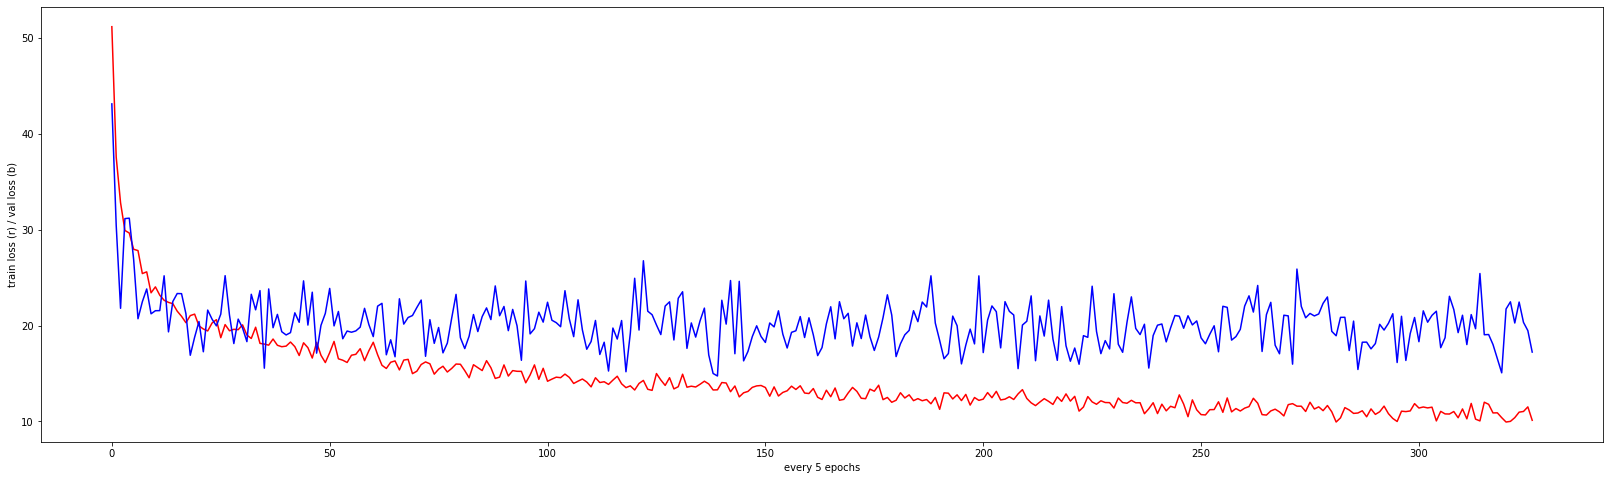

In [24]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=[28,8])
show_results(train_loss,val_loss,plt)